In [1]:
# Import libraries

import matplotlib.pyplot as plt
import pandas as pd
import warnings
from econml.sklearn_extensions.linear_model import WeightedLassoCV
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.metrics as sme
import sklearn.feature_selection as skf
import sklearn.ensemble as ske
import sklearn.utils as sku
from celer import GroupLassoCV
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util
from scipy.spatial import cKDTree

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [3]:
# Maybe y should also be scaled? 
# Perhaps a transform would be more effective, or scaling implemented with consistent cross-validation
# Different scaling methods? 
#     This seems most important for noise-sensitive models like LARS. All other use StandardScaler()
# Transformers?
# Model-specific scaling methods?
#     Yes, see above
# Common cross-validation function ✓
#     Use built-in functions wherever possible and `utils.gridsearch_pickparams()` elsewhere
# Quantile loss
# RANSAC
# Data augmentation? (Mixup)
# Data generation? (SMOGN)
# Combine CHH dataset
# Implement CV and test ✓
# Print selected features ✓
# Make magnitude templates
# Sample weights ✓
# Look at segmentations by error
# Extract features from current (1:6) eroded ROIs
# Extract features from all ROIs
# Plot segmentation variance against error for each case across all ROIs
# Why does excluding the subthalamic nucleus increase the correlation (r=0.5 -> r=0.6)?
# Best performance with all ROIs: cvn=6, k=1800
# Best performance with ROIs 0:4, excluding STN: cvn=6, k=1800

In [4]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,False)

ids = np.asarray(ID_all).astype(int)
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,0:4,:]
K_all_c = K_all[c_cases_idx,0:4,:]
R_all_c = R_all[c_cases_idx,0:4,:]
print(R_all_c)
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
subsc = subs[s_cases_idx]
pre_imp = pre_imp[s_cases_idx]
post_imp = post_imp[s_cases_idx]
pre_updrs_off = pre_updrs_off[s_cases_idx]
per_change = post_imp
# Reshape keys and ROIs
K_all_cu = np.empty((K_all_c.shape[0],K_all_c.shape[1],K_all_c.shape[2]+1),dtype=object)
K_all_cu[:,:,:-1] = K_all_c
K_all_cu[:,:,-1] = 'pre_updrs'
K = K_all_cu.reshape((K_all_cu.shape[0],K_all_cu.shape[1]*K_all_cu.shape[2]))[0]
R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))

Allocated arrays
Created feature matrix
Created ROI matrix
Created feature label matrix
[[['Left red nucleus' 'Left red nucleus' 'Left red nucleus' ...
   'Left red nucleus' 'Left red nucleus' 'Left red nucleus']
  ['Right red nucleus' 'Right red nucleus' 'Right red nucleus' ...
   'Right red nucleus' 'Right red nucleus' 'Right red nucleus']
  ['Left substantia nigra' 'Left substantia nigra'
   'Left substantia nigra' ... 'Left substantia nigra'
   'Left substantia nigra' 'Left substantia nigra']
  ['Right Substantia nigra' 'Right Substantia nigra'
   'Right Substantia nigra' ... 'Right Substantia nigra'
   'Right Substantia nigra' 'Right Substantia nigra']]

 [['Left red nucleus' 'Left red nucleus' 'Left red nucleus' ...
   'Left red nucleus' 'Left red nucleus' 'Left red nucleus']
  ['Right red nucleus' 'Right red nucleus' 'Right red nucleus' ...
   'Right red nucleus' 'Right red nucleus' 'Right red nucleus']
  ['Left substantia nigra' 'Left substantia nigra'
   'Left substantia nigra

In [12]:
scoring = 'r2'
results_bls = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_gls = np.zeros_like(per_change)
gerror = np.zeros_like(per_change)
alphas = np.logspace(-4,4,100)
Ks = []
w = []

Lasso predicts 0.47 for case with 0.48 with regularization 0.0082 and neighbor  [0.67241379]


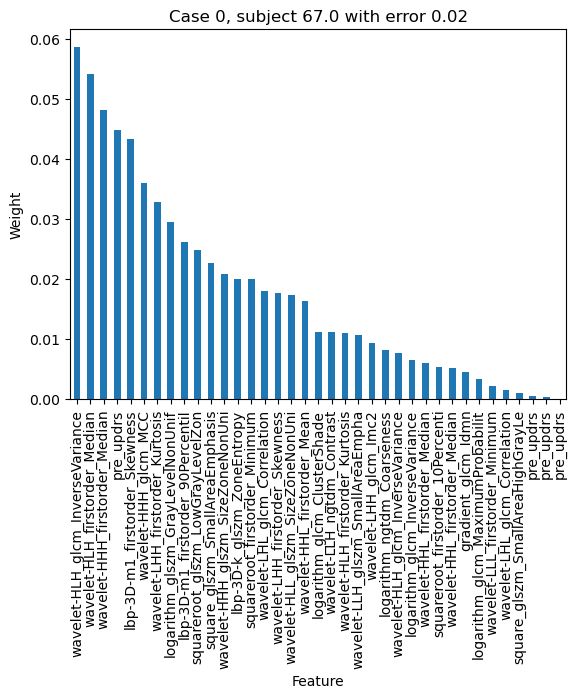

Lasso predicts 0.59 for case with 0.97 with regularization 0.0111 and neighbor  [0.87878788]


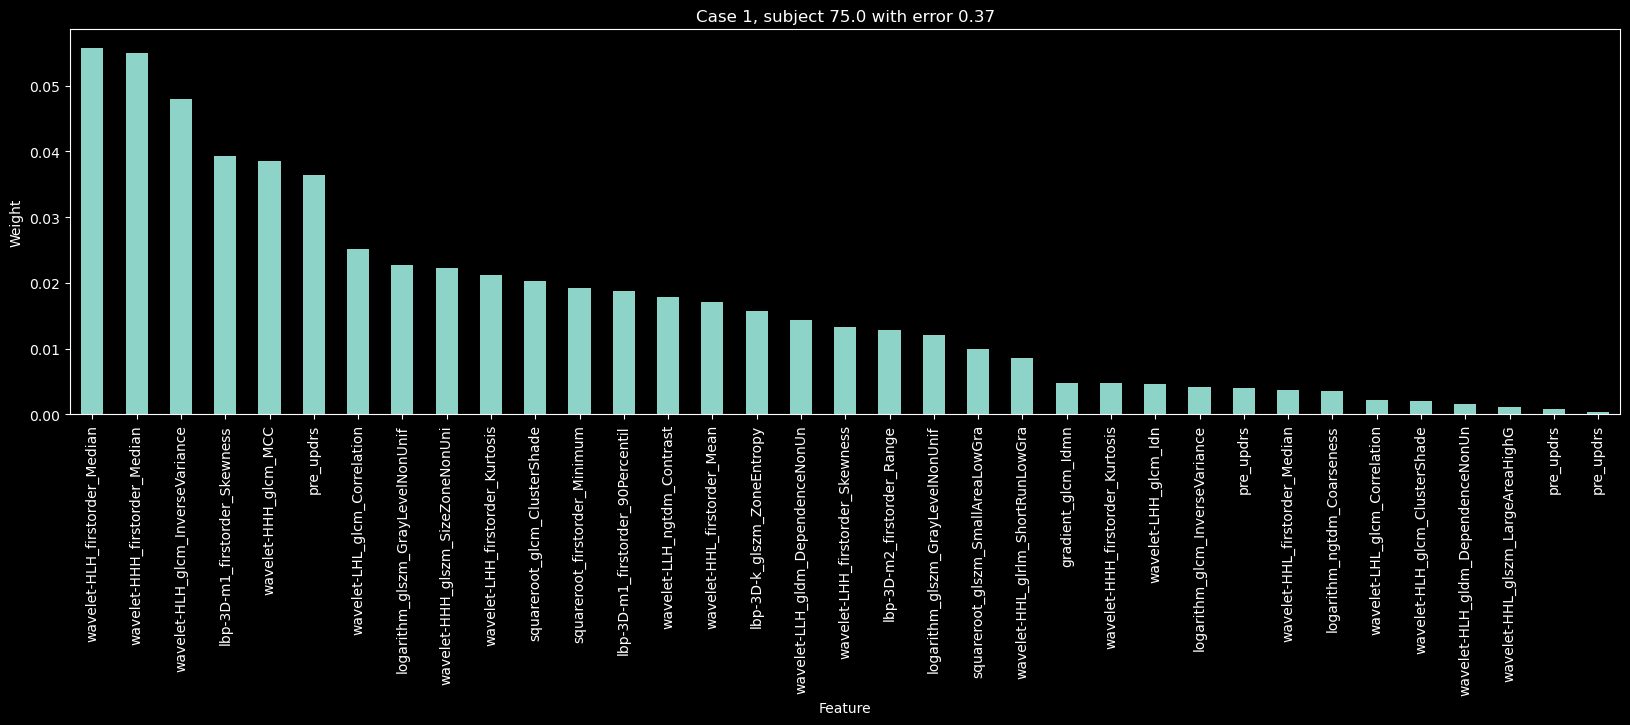

Lasso predicts 0.51 for case with 0.75 with regularization 0.0059 and neighbor  [0.1875]


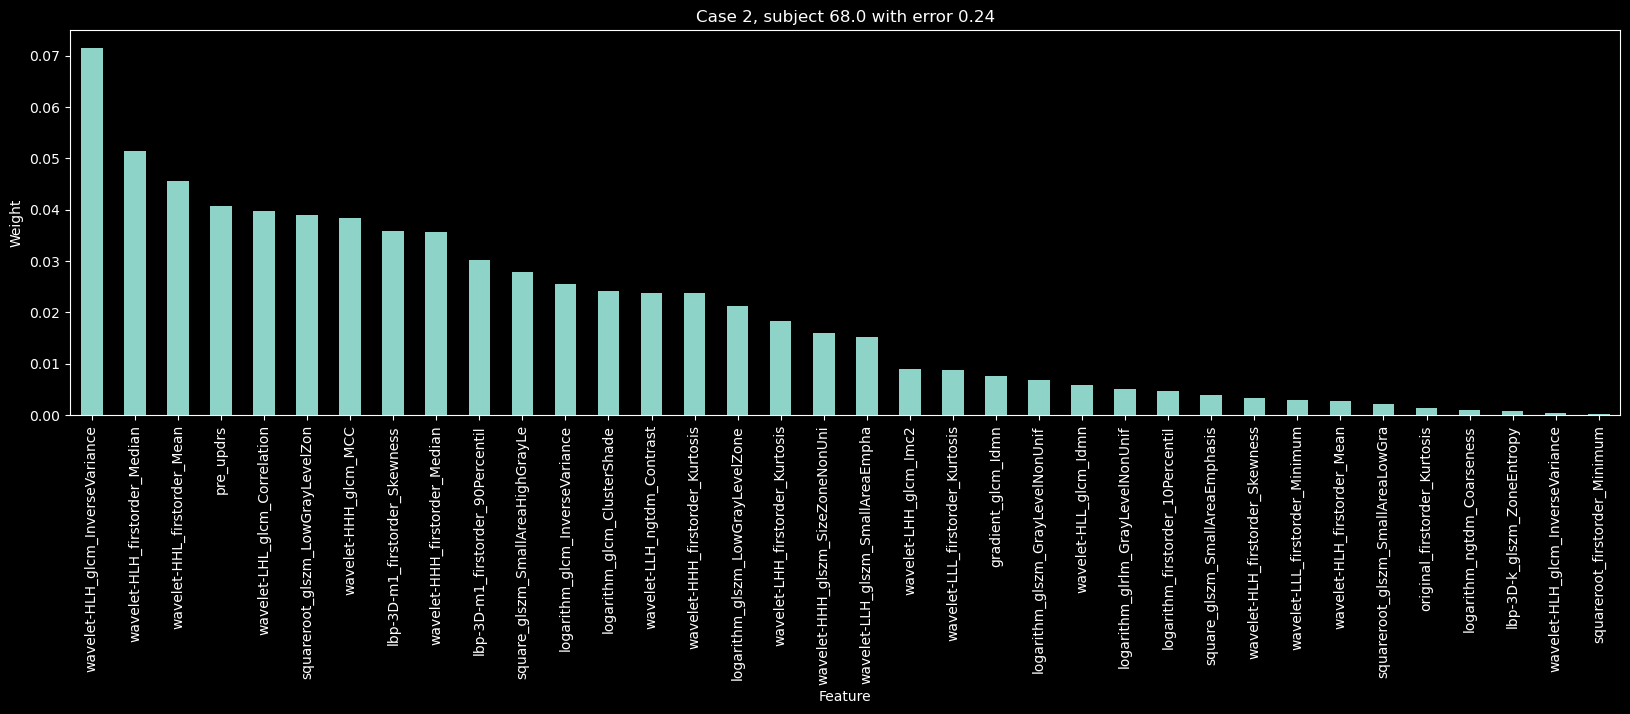

Lasso predicts 0.67 for case with 0.66 with regularization 0.0055 and neighbor  [0.83928571]


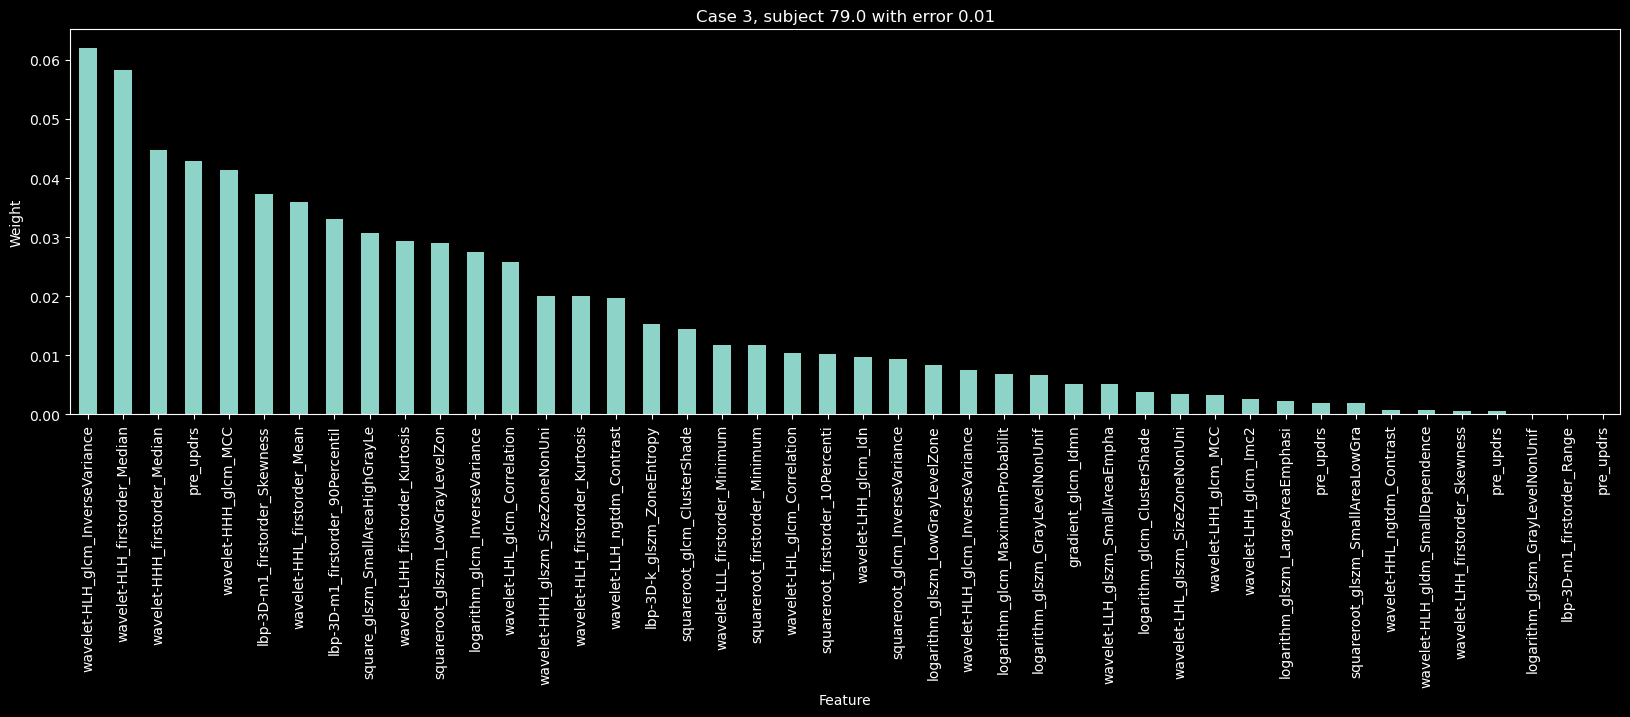

Lasso predicts 0.91 for case with 0.74 with regularization 0.0081 and neighbor  [0.84615385]


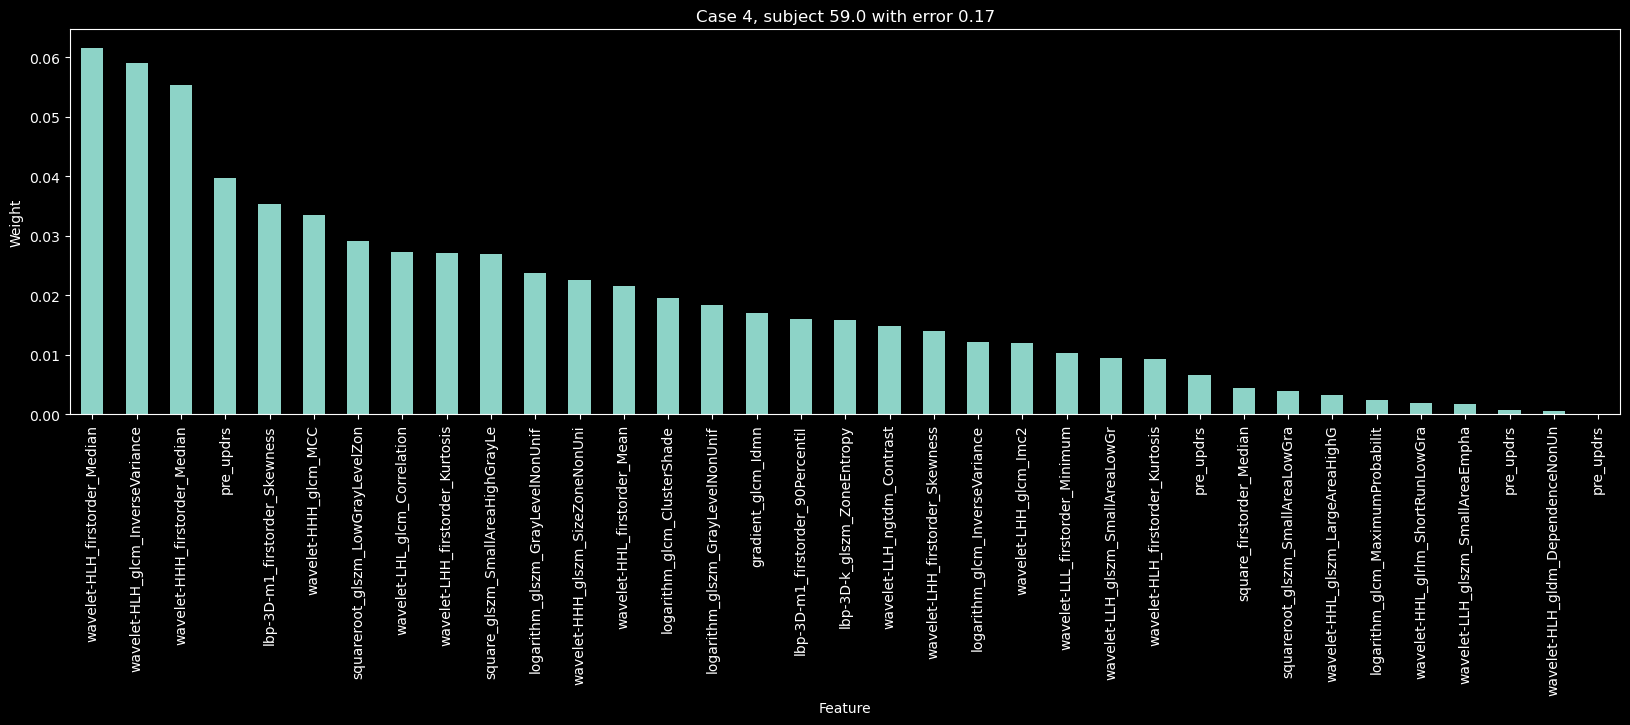

Lasso predicts 0.47 for case with 0.15 with regularization 0.0152 and neighbor  [0.67241379]


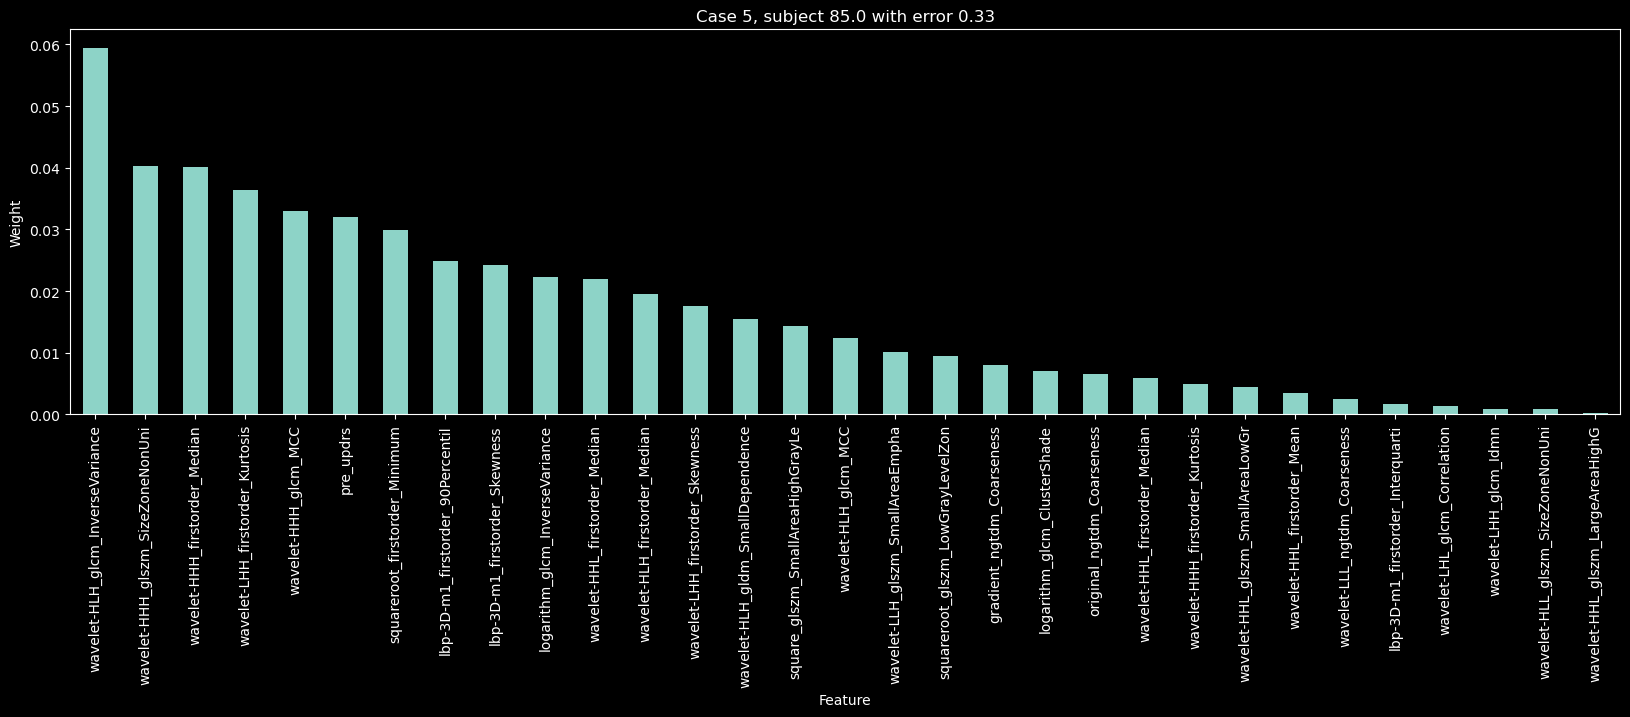

Lasso predicts 0.86 for case with 0.85 with regularization 0.0108 and neighbor  [0.87878788]


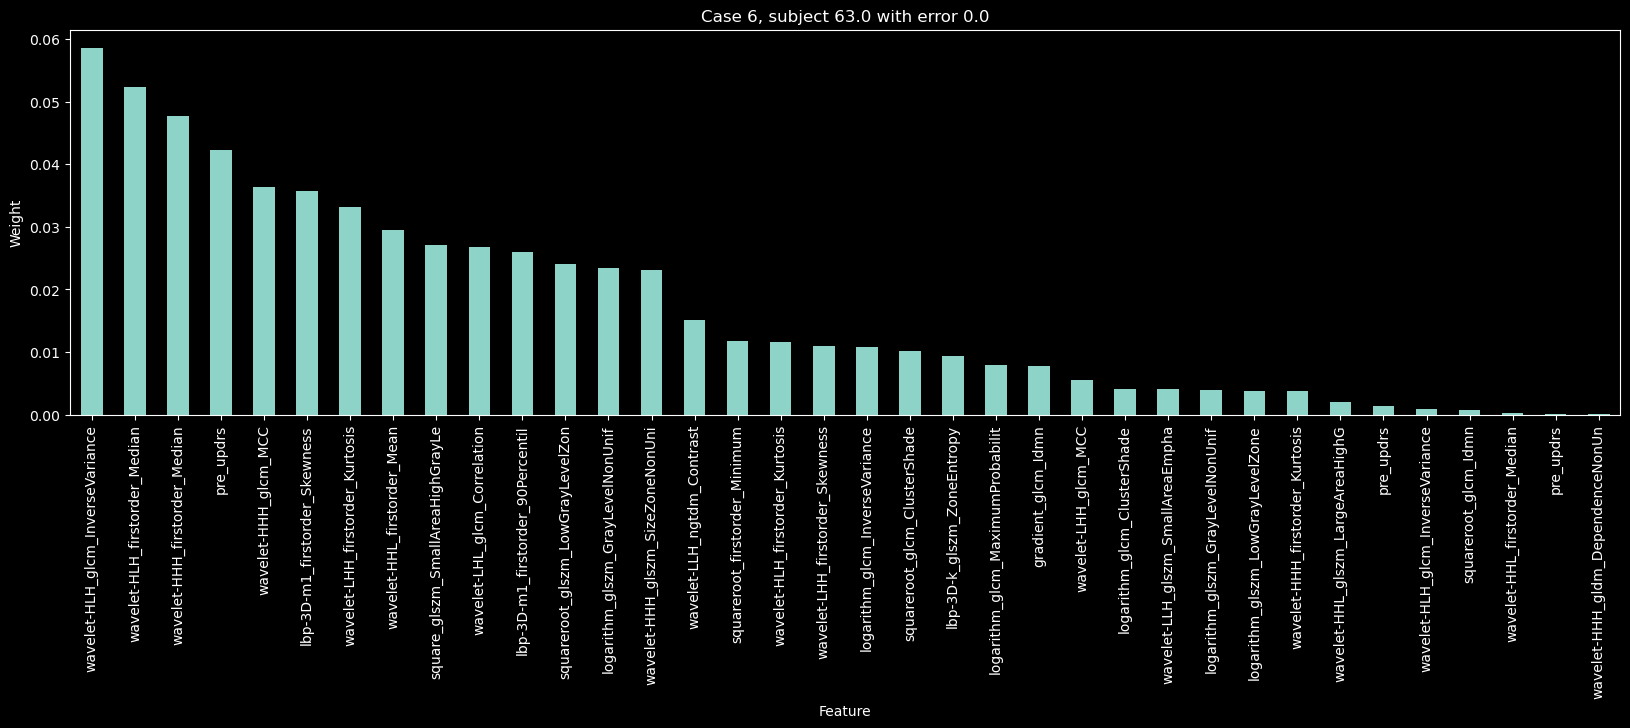

Lasso predicts 0.35 for case with 0.53 with regularization 0.0034 and neighbor  [0.42857143]


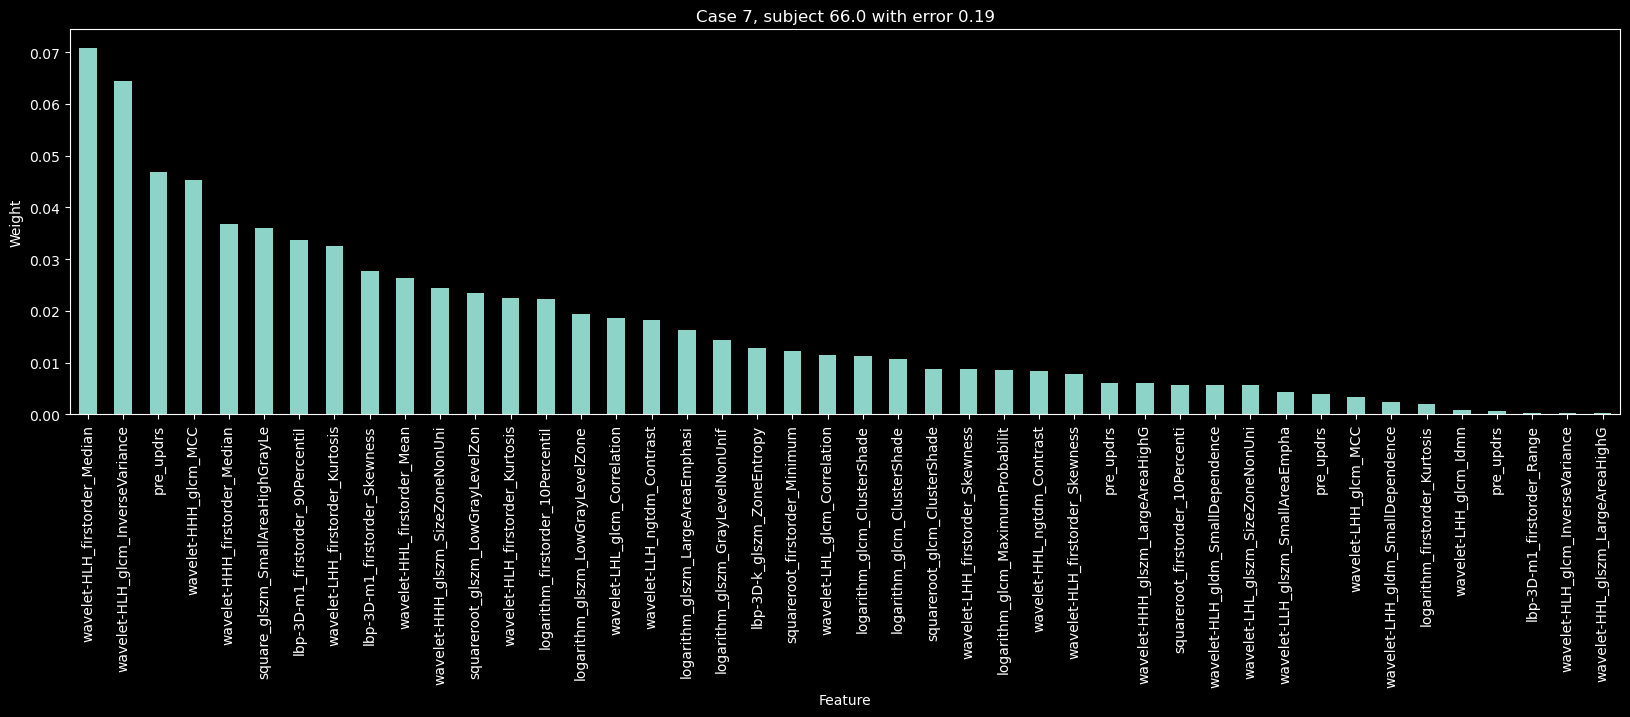

Lasso predicts 0.65 for case with 0.5 with regularization 0.0001 and neighbor  [0.66153846]


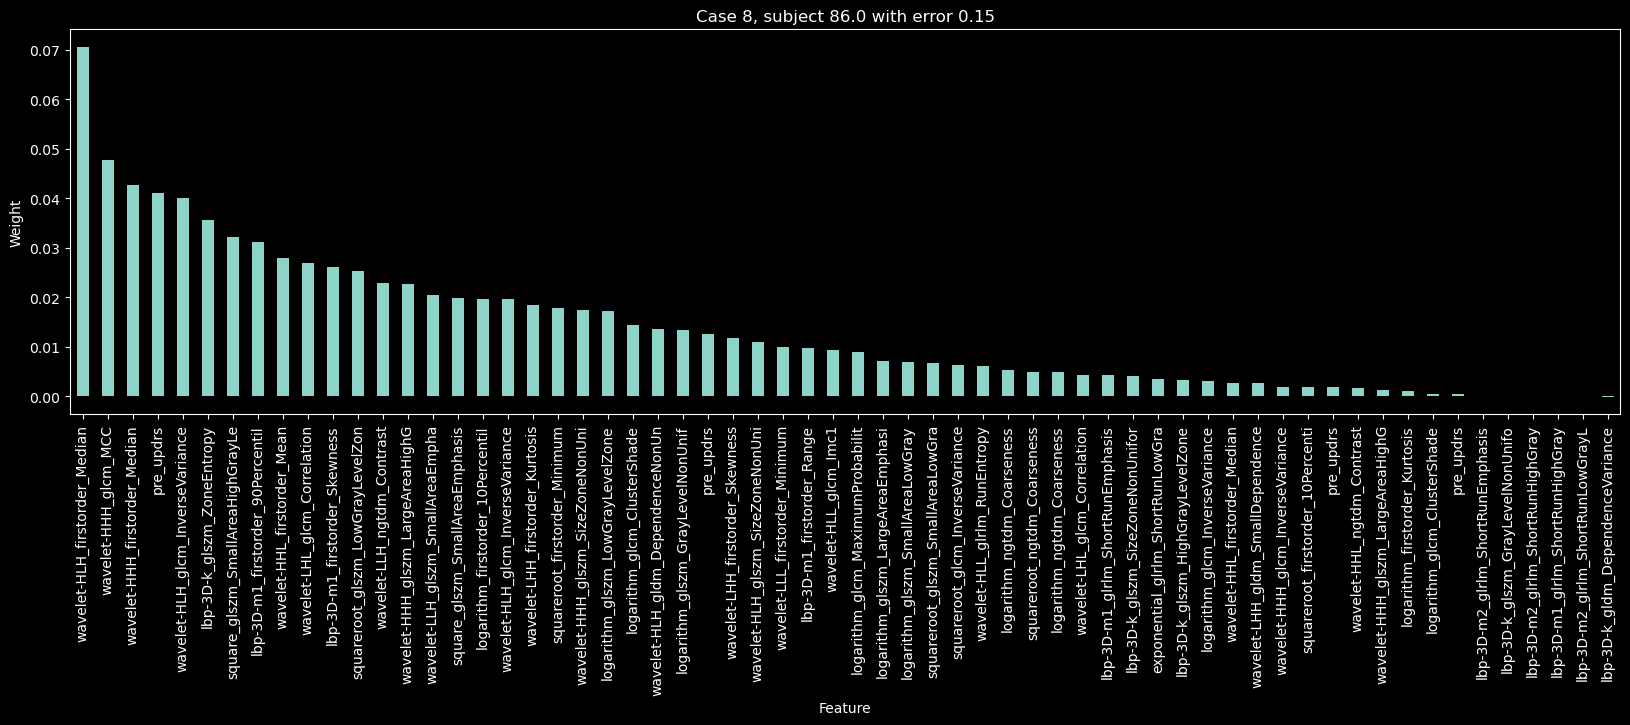

Lasso predicts 0.58 for case with 0.49 with regularization 0.0141 and neighbor  [0.55555556]


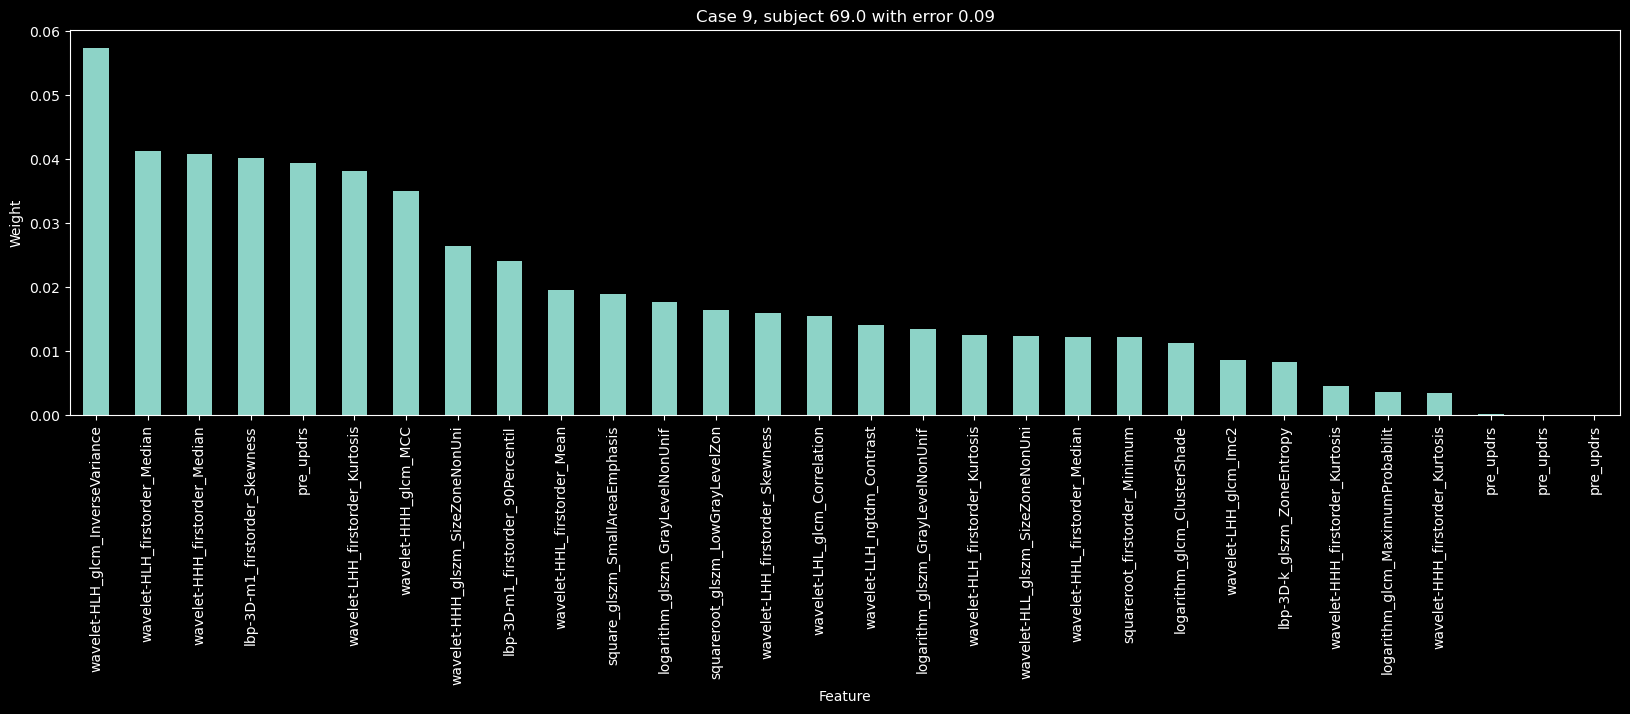

Lasso predicts 0.48 for case with 0.26 with regularization 0.0016 and neighbor  [0.88311688]


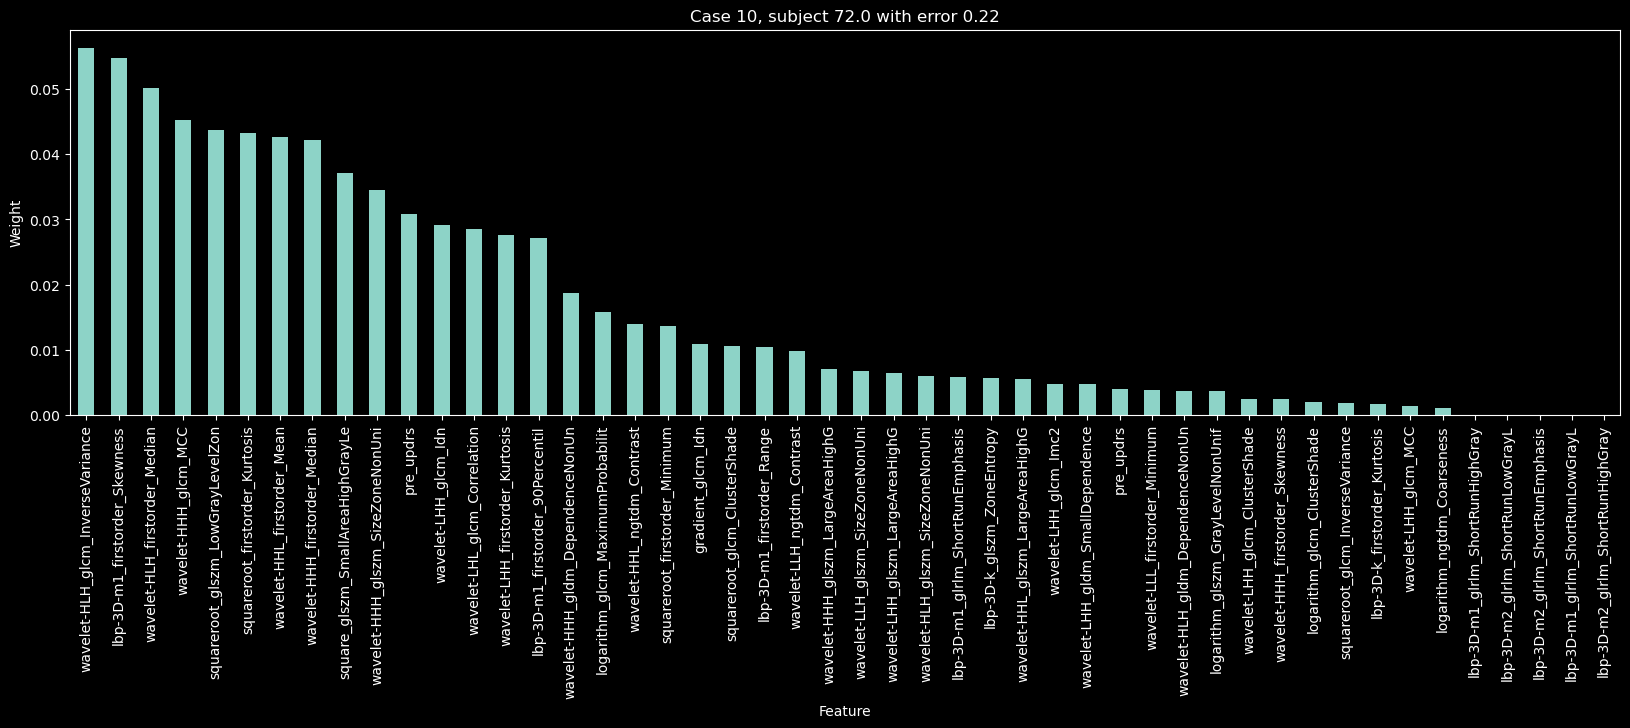

Lasso predicts 0.63 for case with 0.52 with regularization 0.0101 and neighbor  [0.96774194]


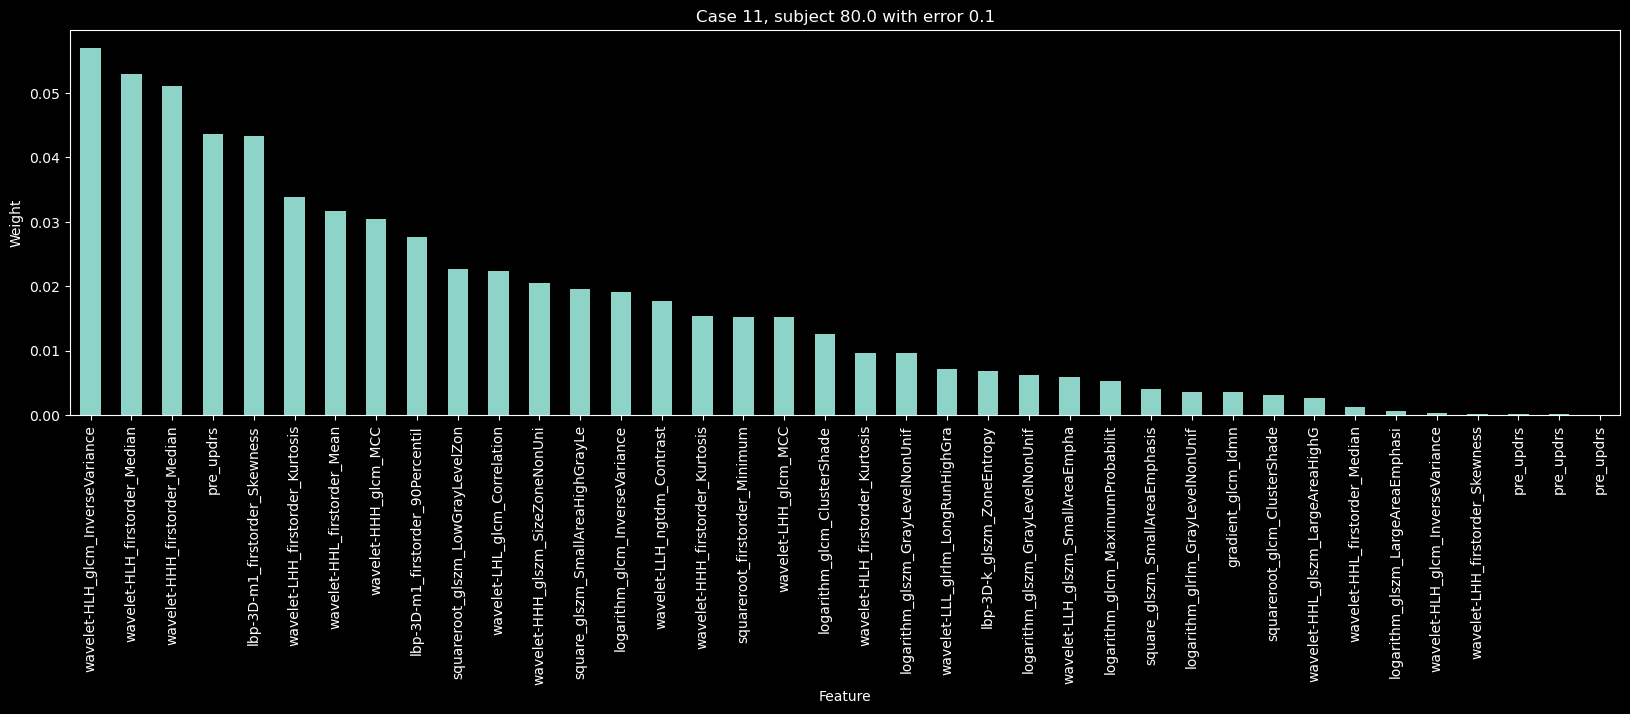

Lasso predicts 0.52 for case with 0.19 with regularization 0.0041 and neighbor  [0.83076923]


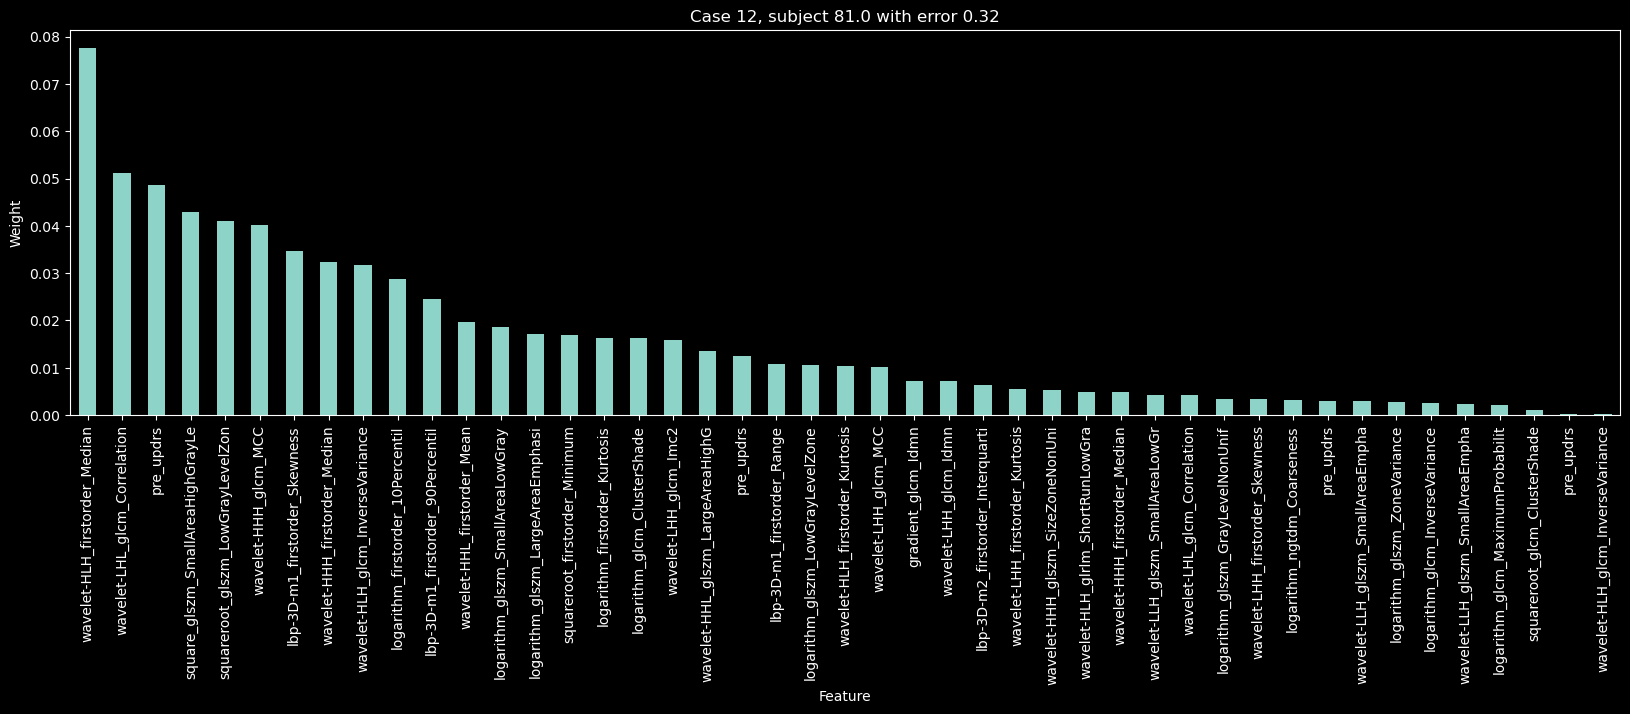

Lasso predicts 0.68 for case with 0.56 with regularization 0.0034 and neighbor  [0.87301587]


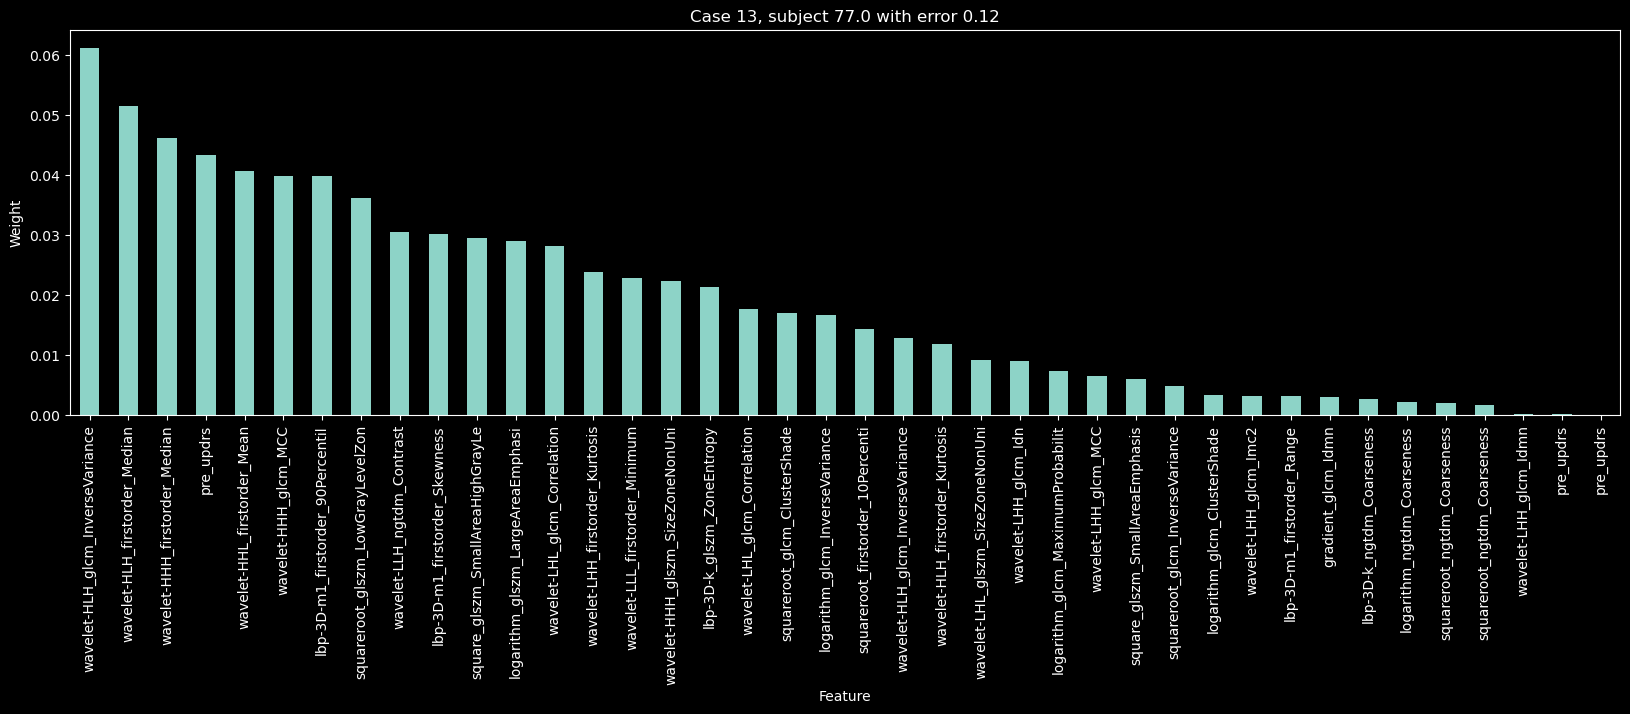

Lasso predicts 0.92 for case with 0.66 with regularization 0.0082 and neighbor  [0.7]


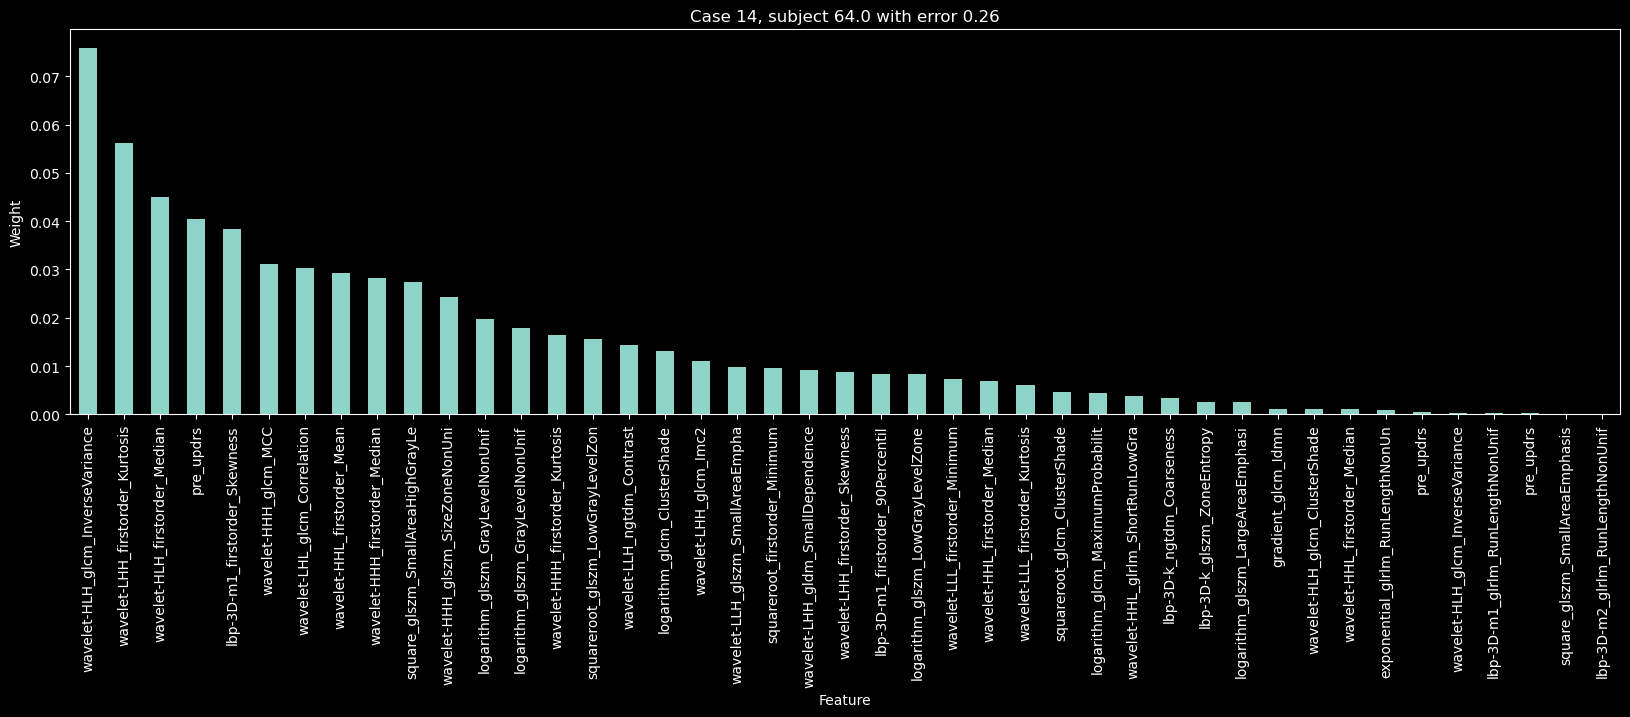

Lasso predicts 0.7 for case with 0.84 with regularization 0.0094 and neighbor  [0.88311688]


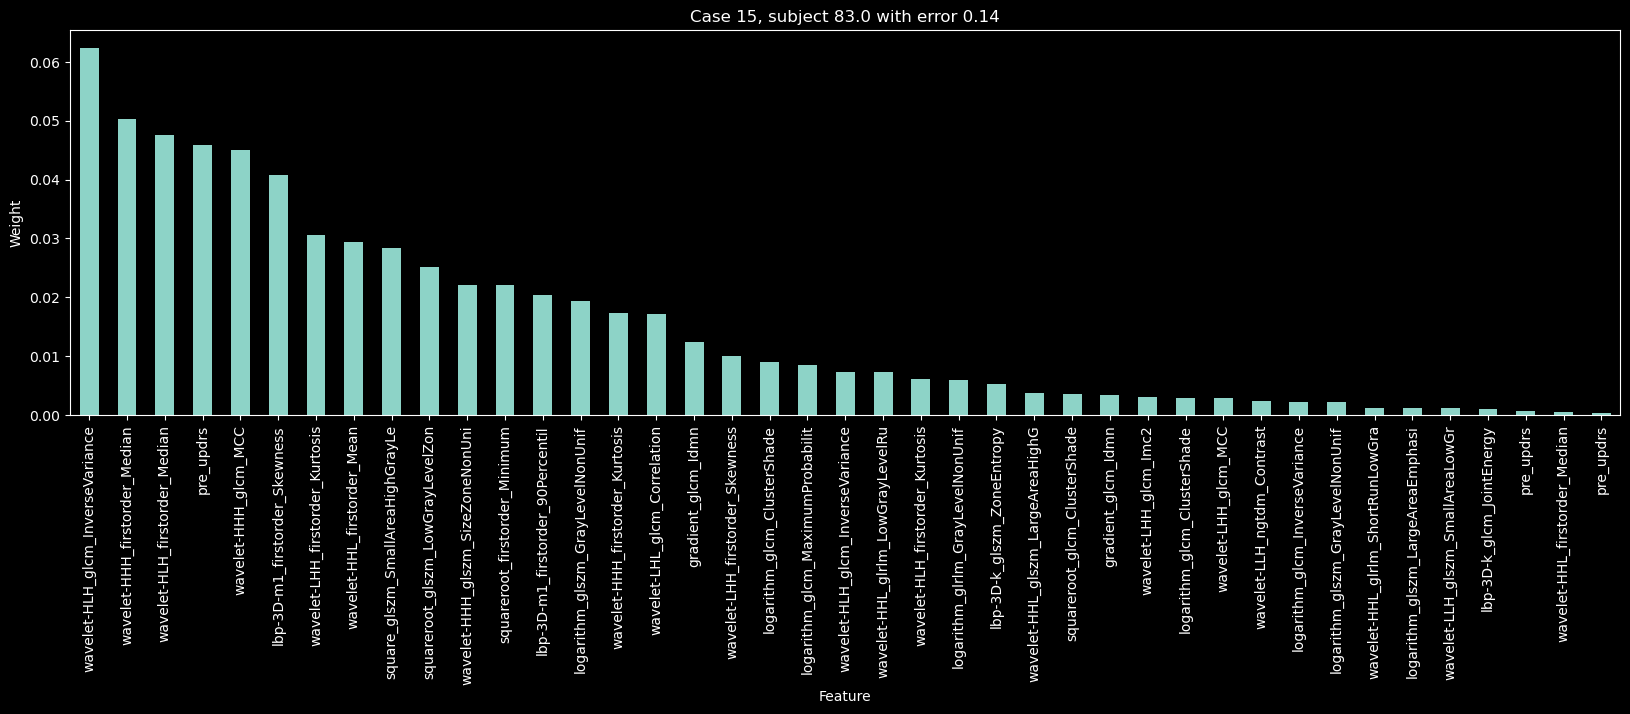

Lasso predicts 0.35 for case with 0.47 with regularization 0.0001 and neighbor  [0.55555556]


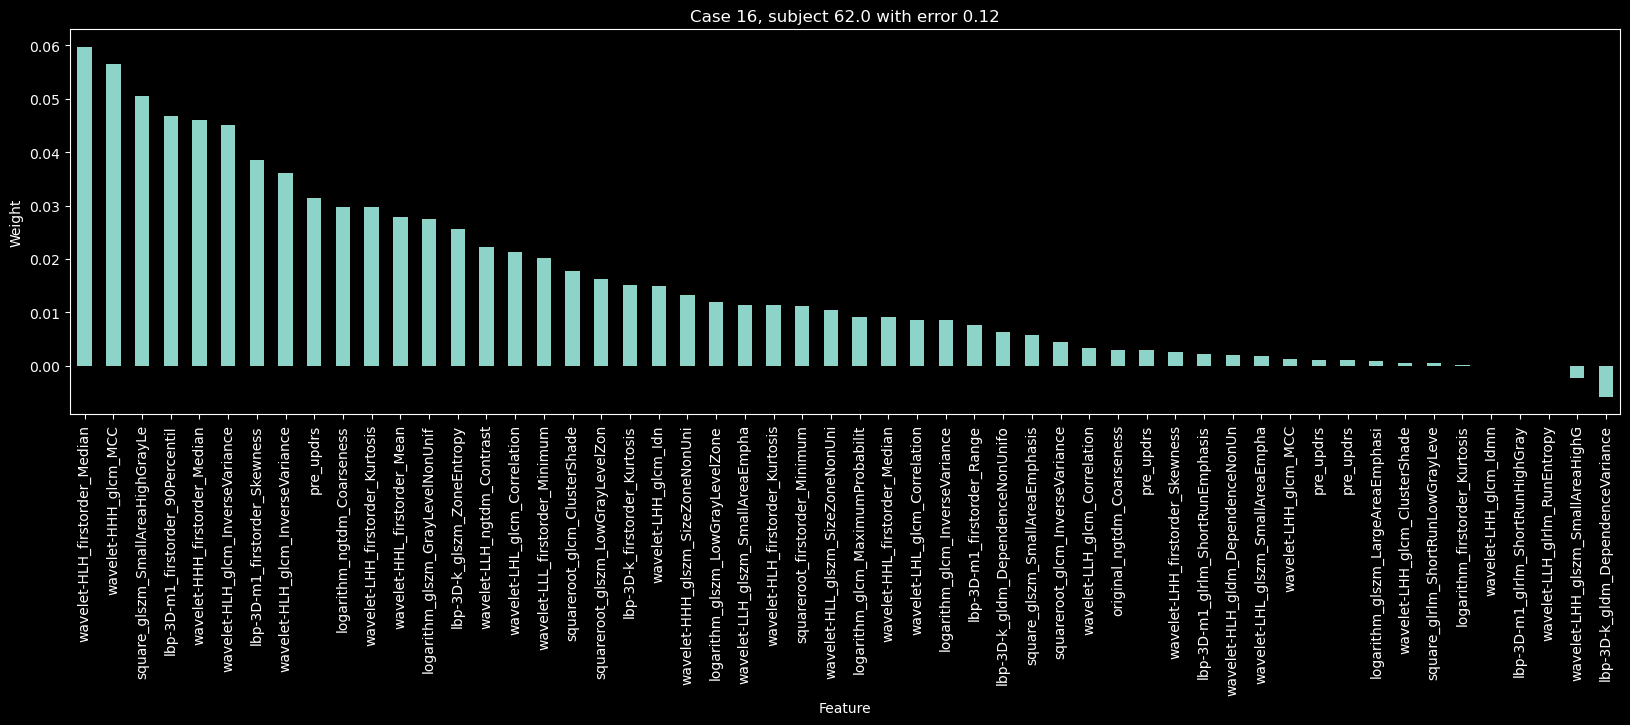

Lasso predicts 0.48 for case with 0.09 with regularization 0.0007 and neighbor  [0.1875]


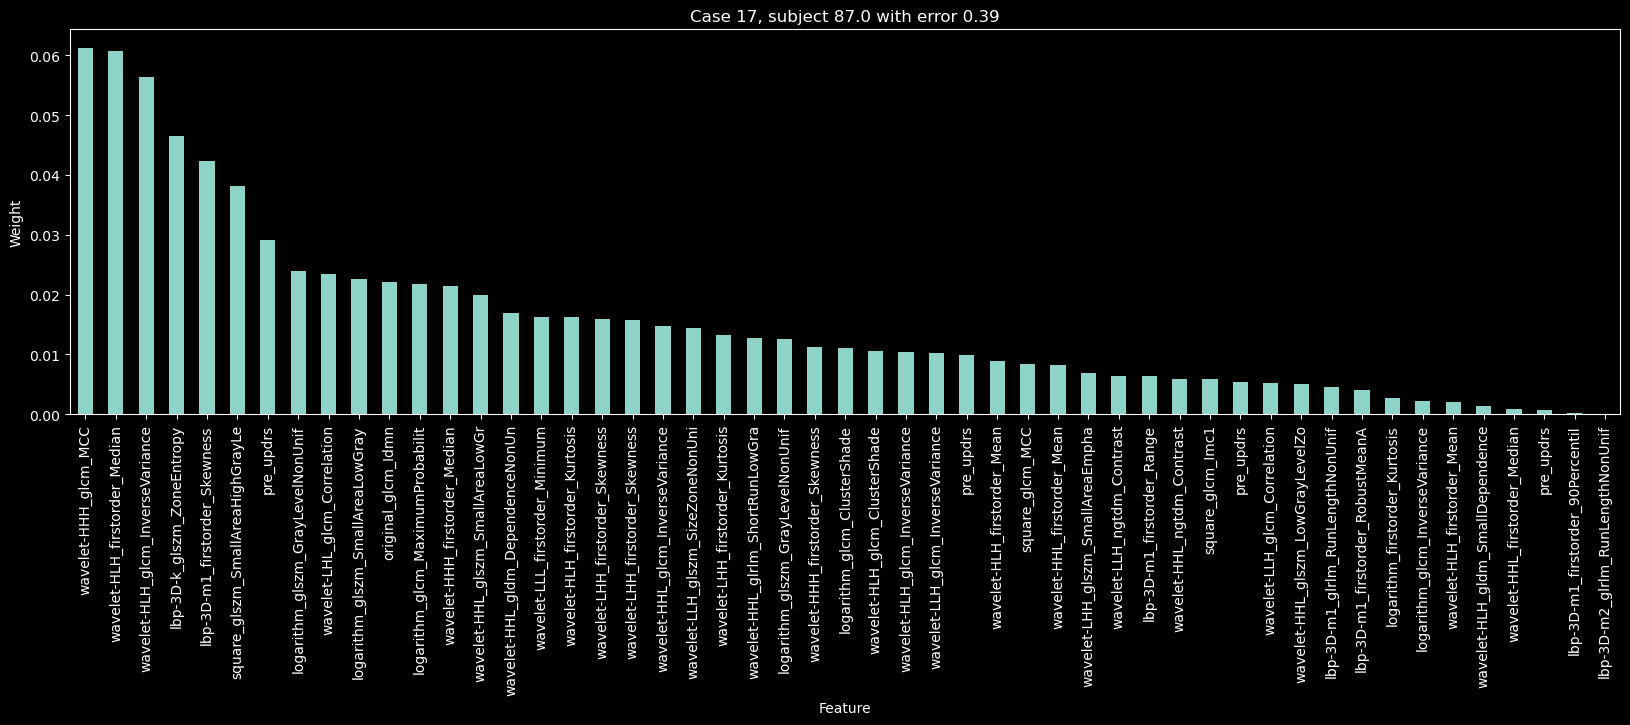

Lasso predicts 0.7 for case with 0.52 with regularization 0.0116 and neighbor  [0.69135802]


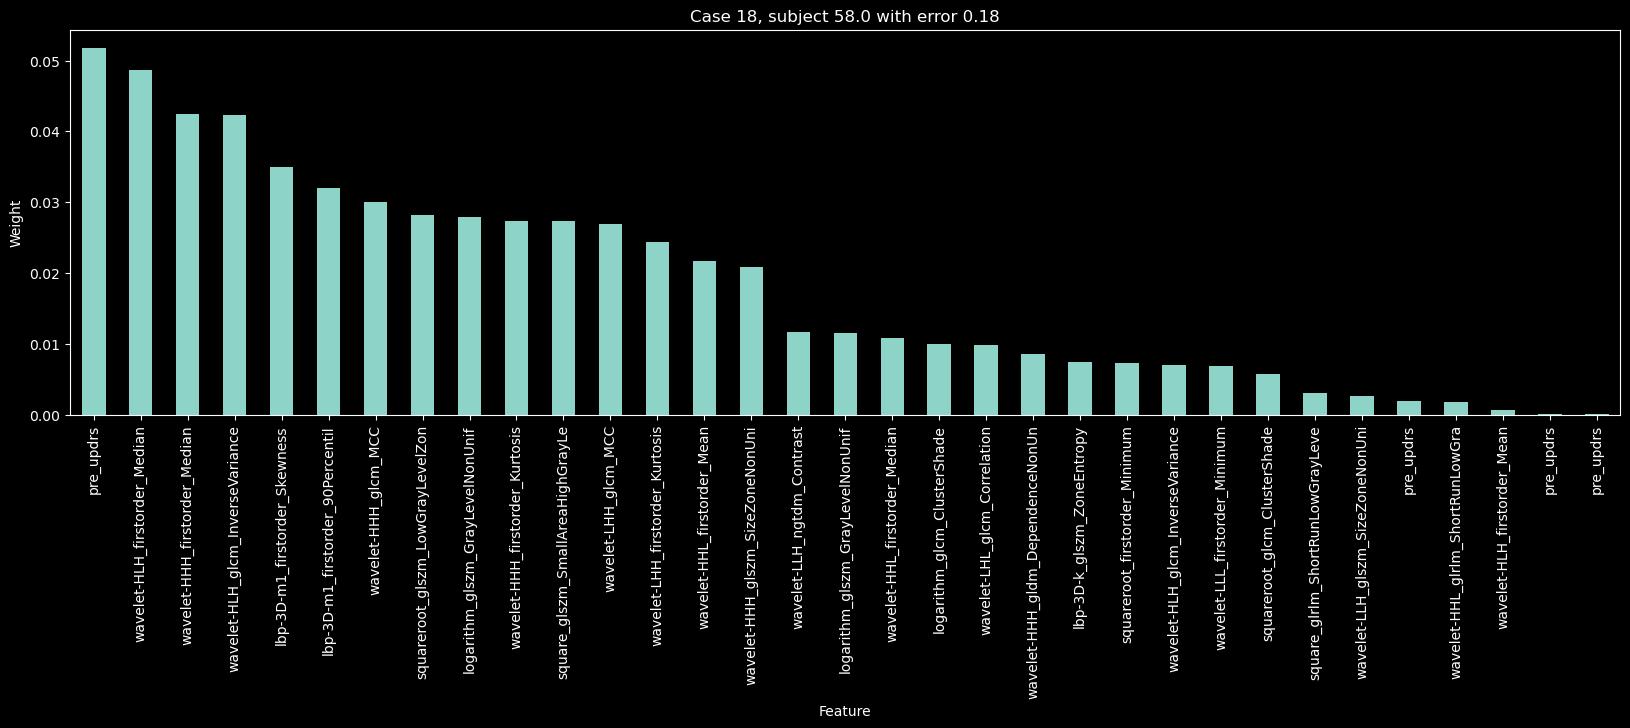

Lasso predicts 0.5 for case with 0.36 with regularization 0.0072 and neighbor  [0.14705882]


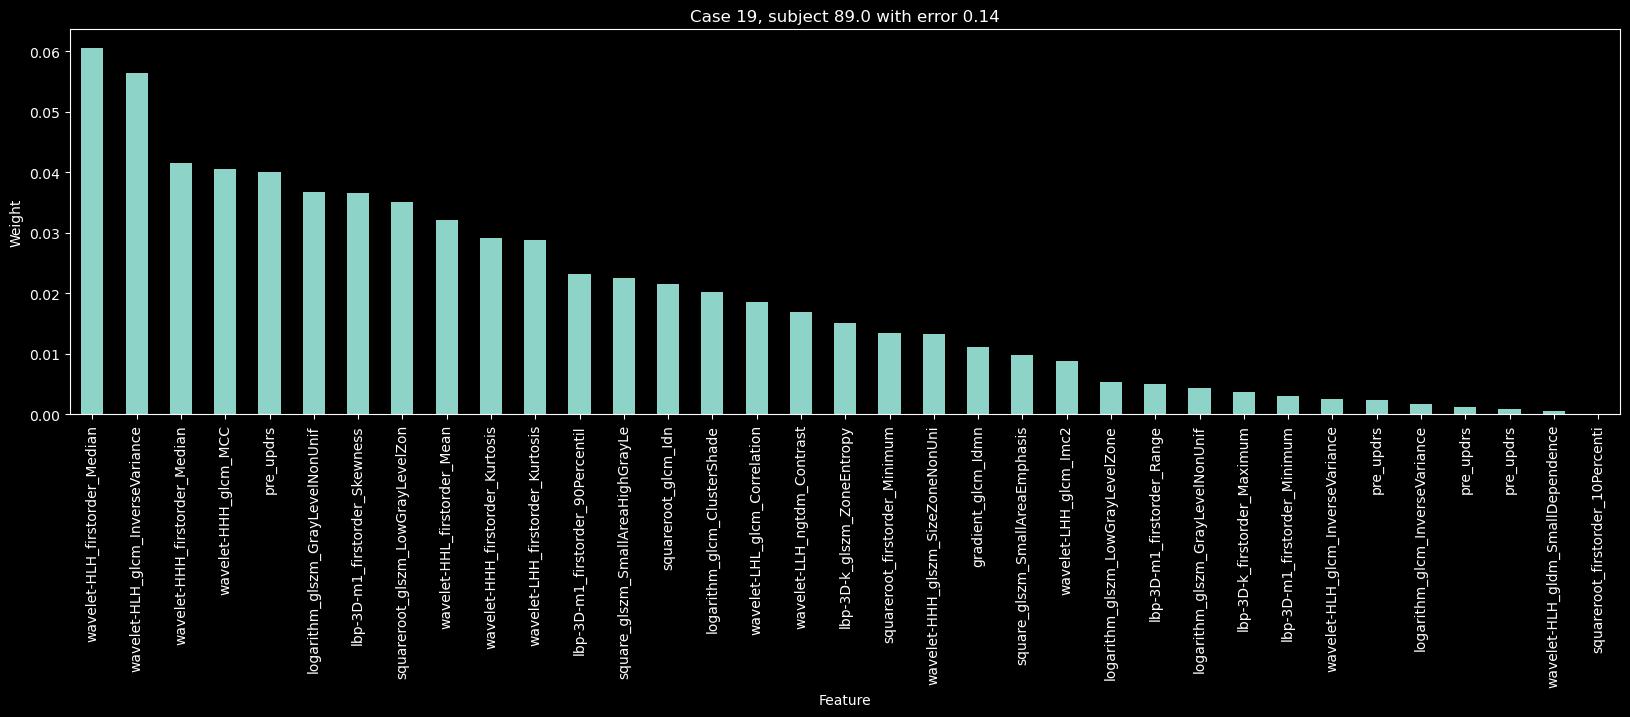

Lasso predicts 0.5 for case with 0.82 with regularization 0.0102 and neighbor  [0.42857143]


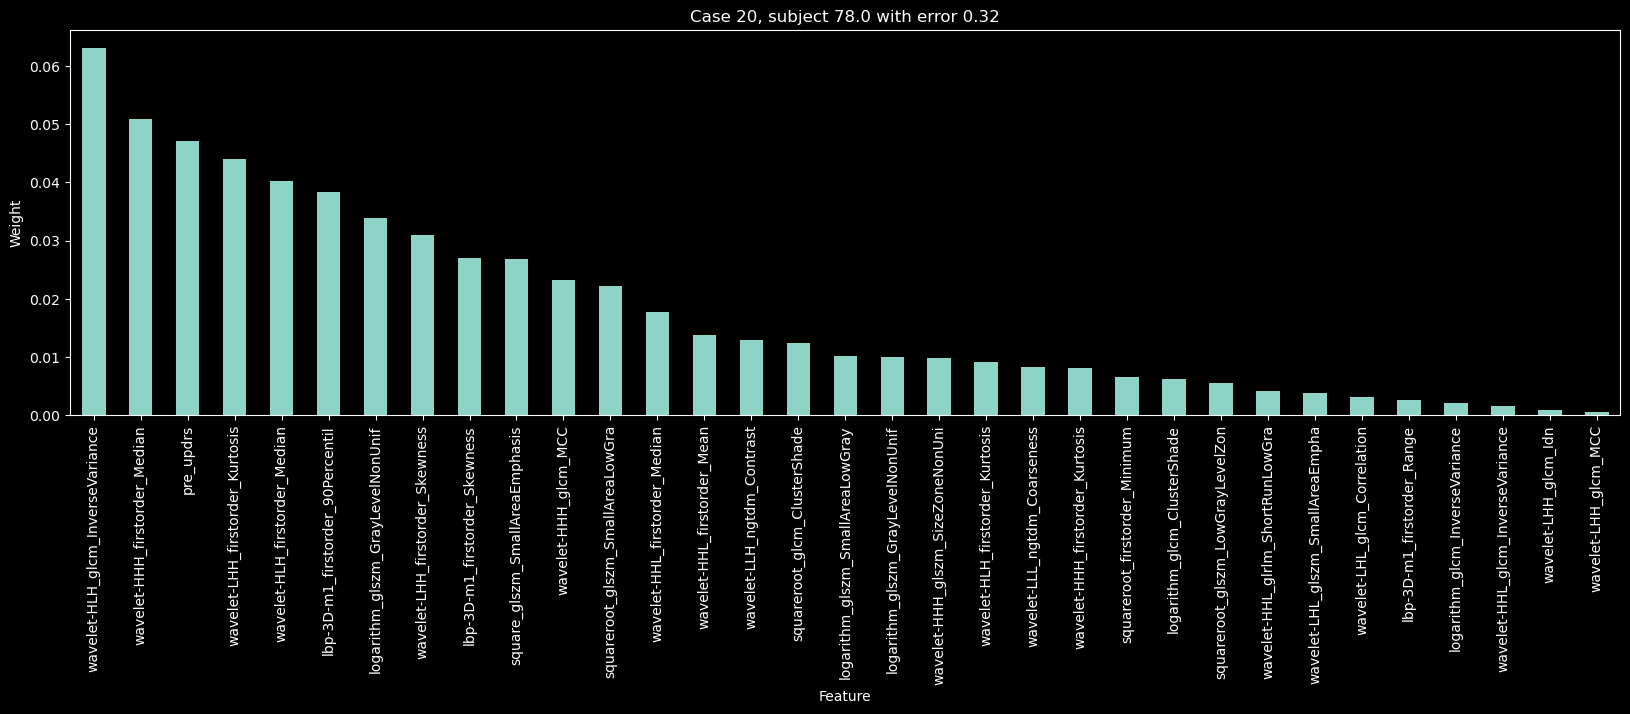

Lasso predicts 0.38 for case with 0.3 with regularization 0.0001 and neighbor  [0.42857143]


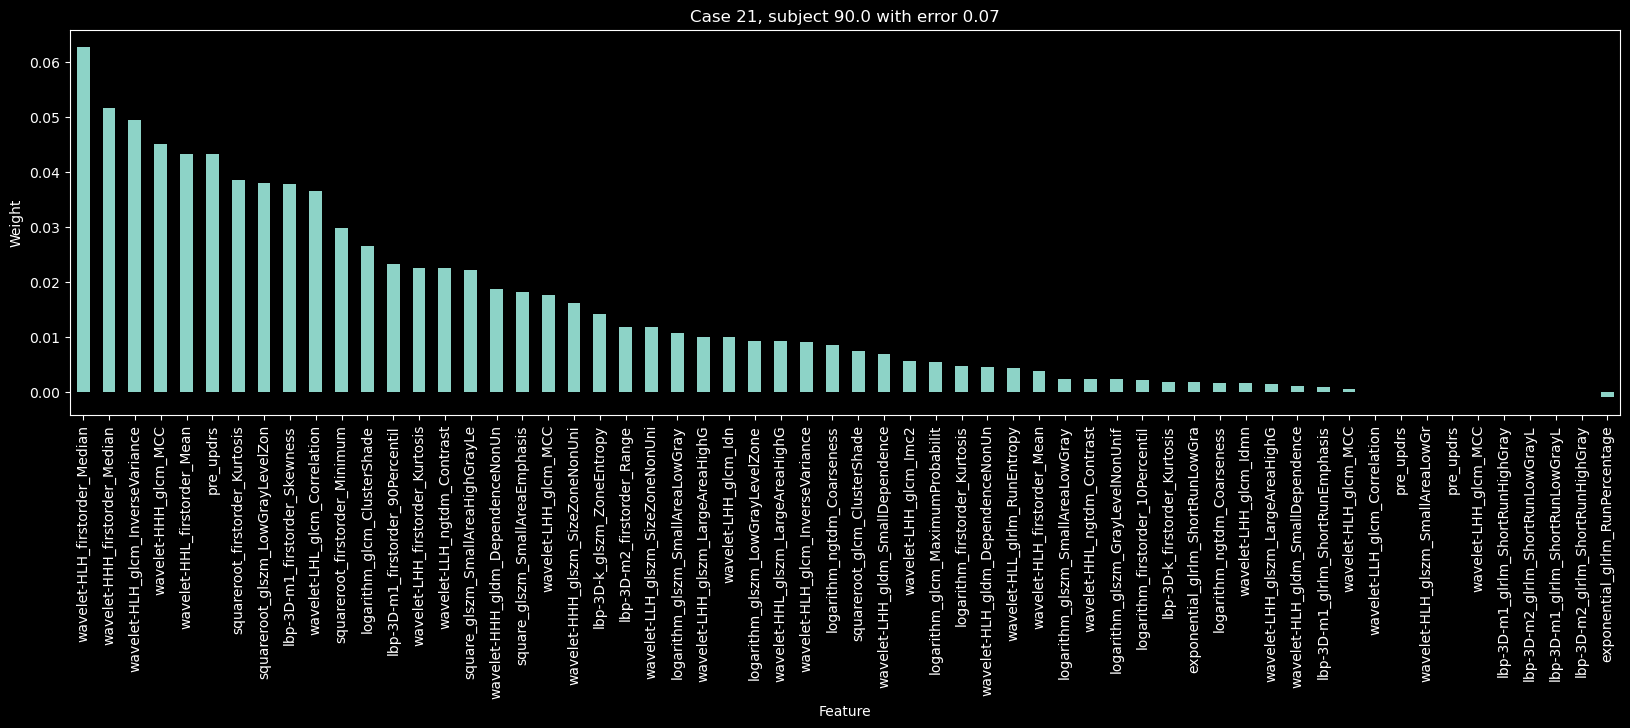

Lasso predicts 0.57 for case with 0.85 with regularization 0.0128 and neighbor  [0.7037037]


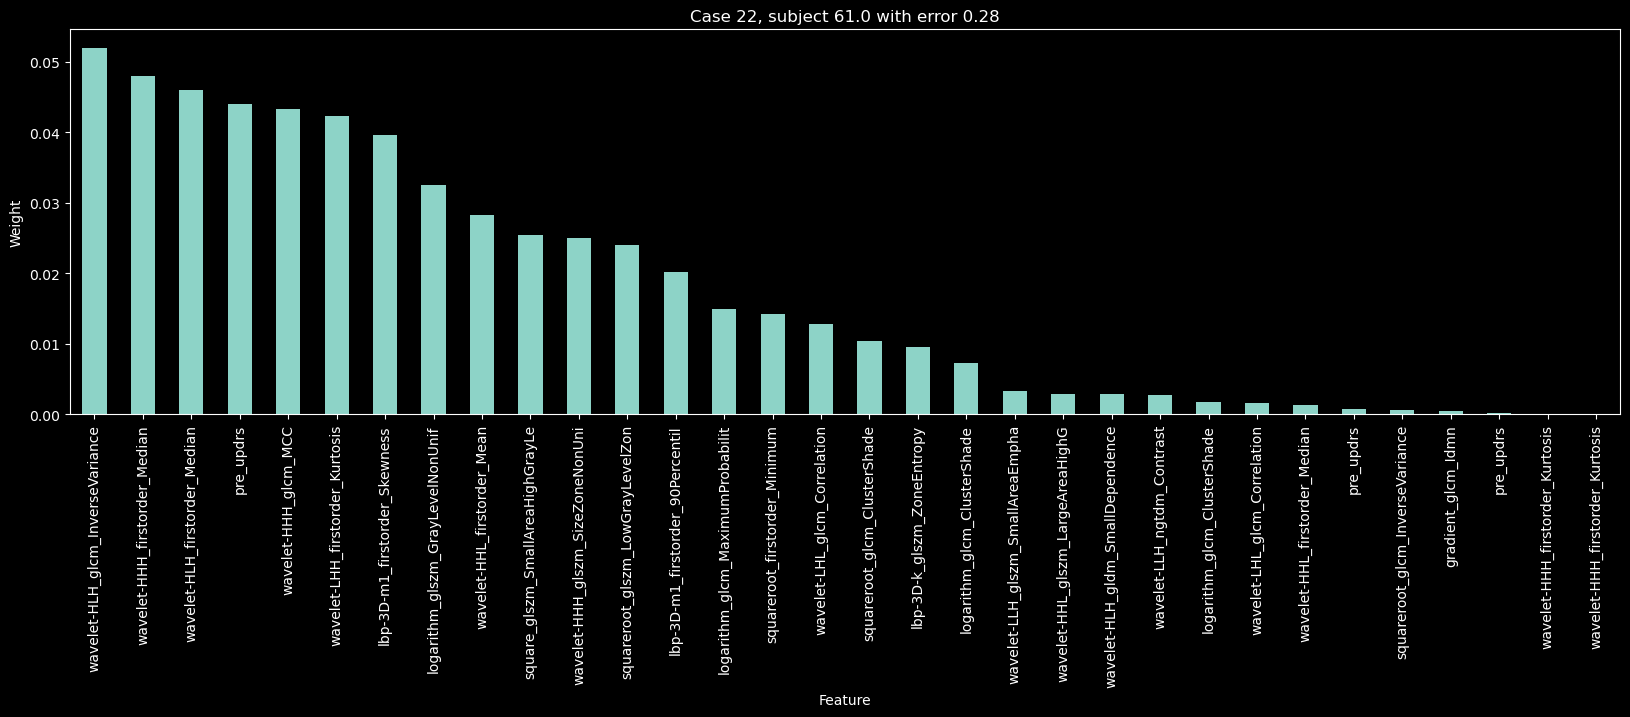

Lasso predicts 0.69 for case with 0.83 with regularization 0.0002 and neighbor  [0.19444444]


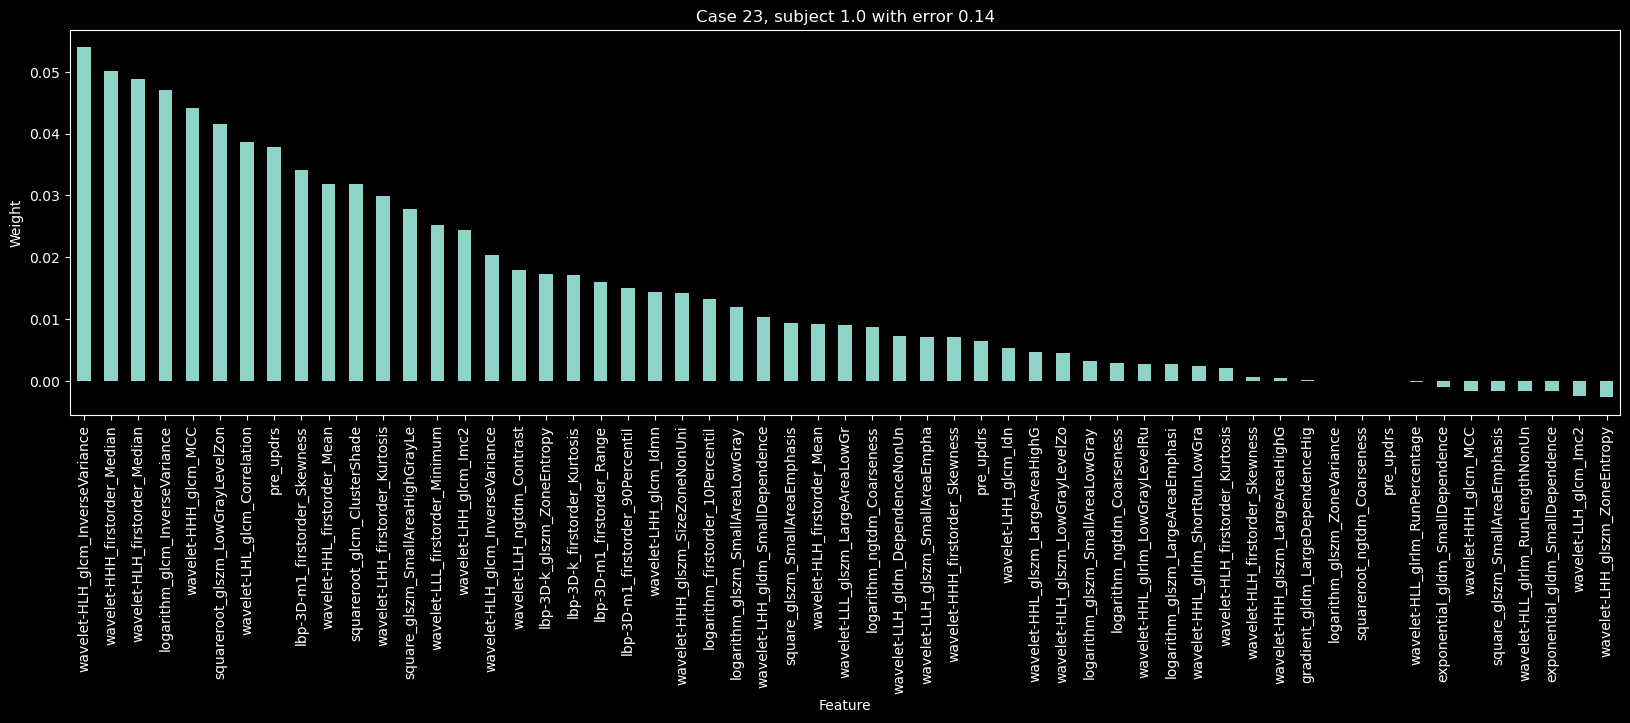

Lasso predicts 0.69 for case with 0.91 with regularization 0.0041 and neighbor  [0.53125]


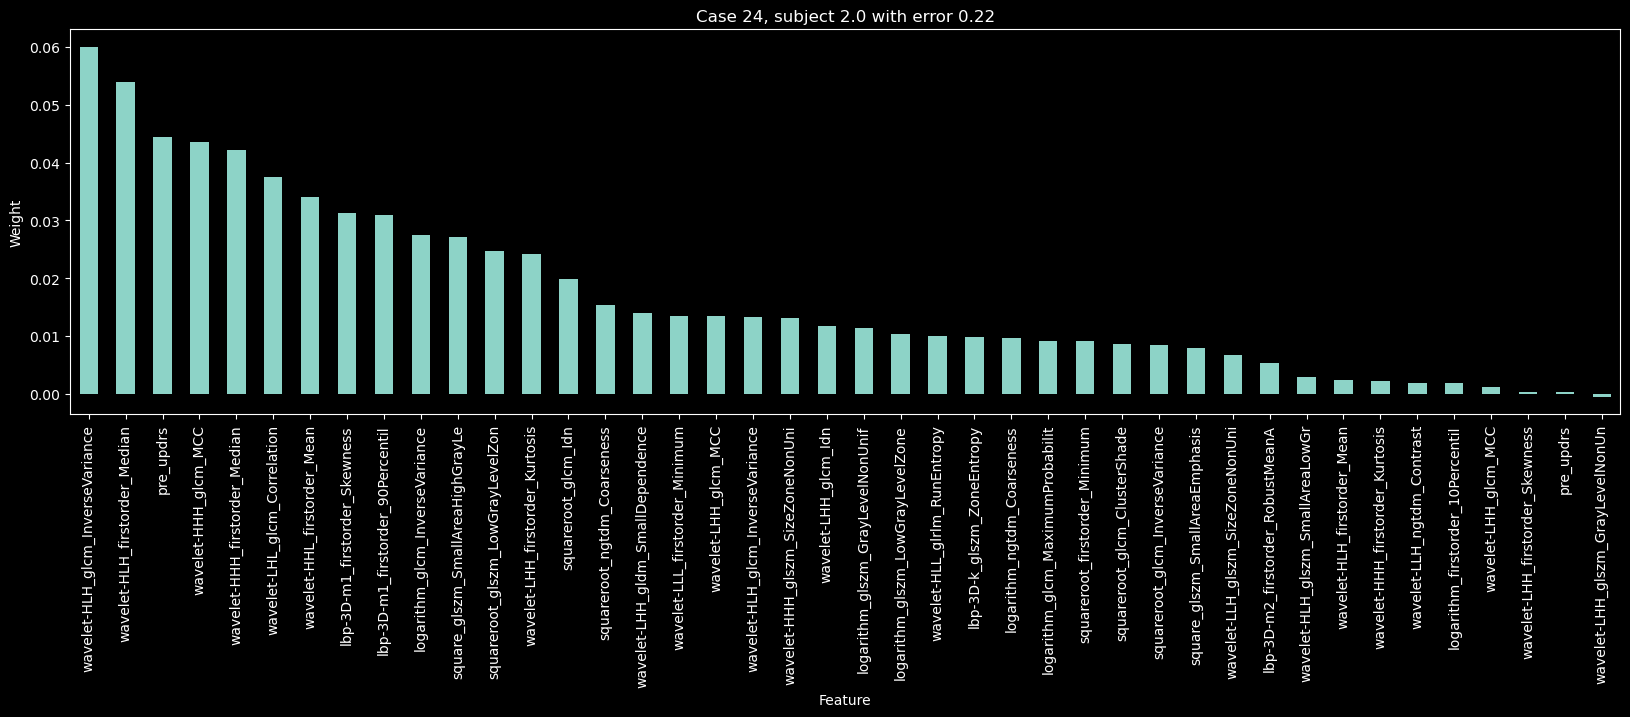

Lasso predicts 0.53 for case with 0.56 with regularization 0.0014 and neighbor  [0.51724138]


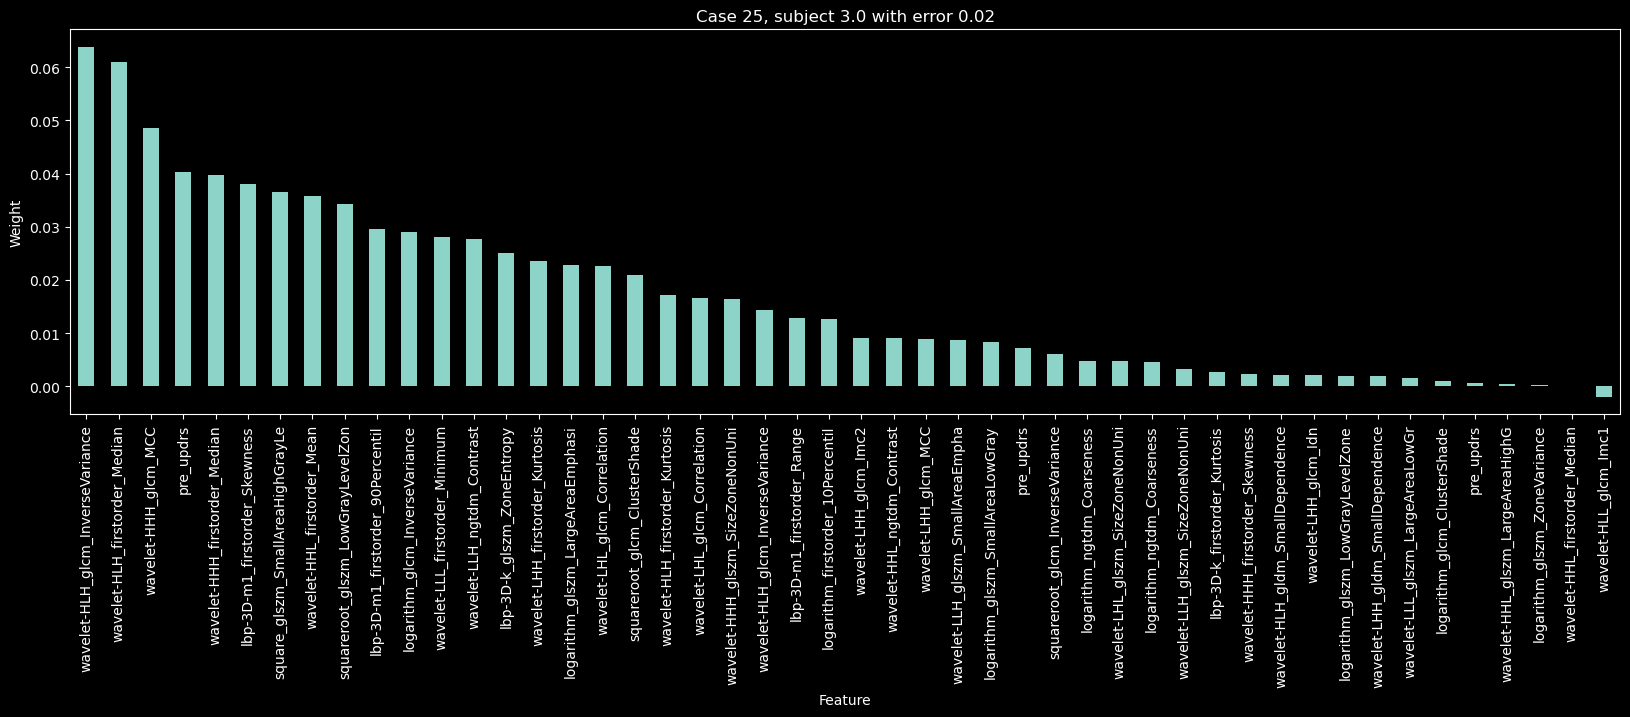

Lasso predicts 0.88 for case with 0.95 with regularization 0.0072 and neighbor  [0.55555556]


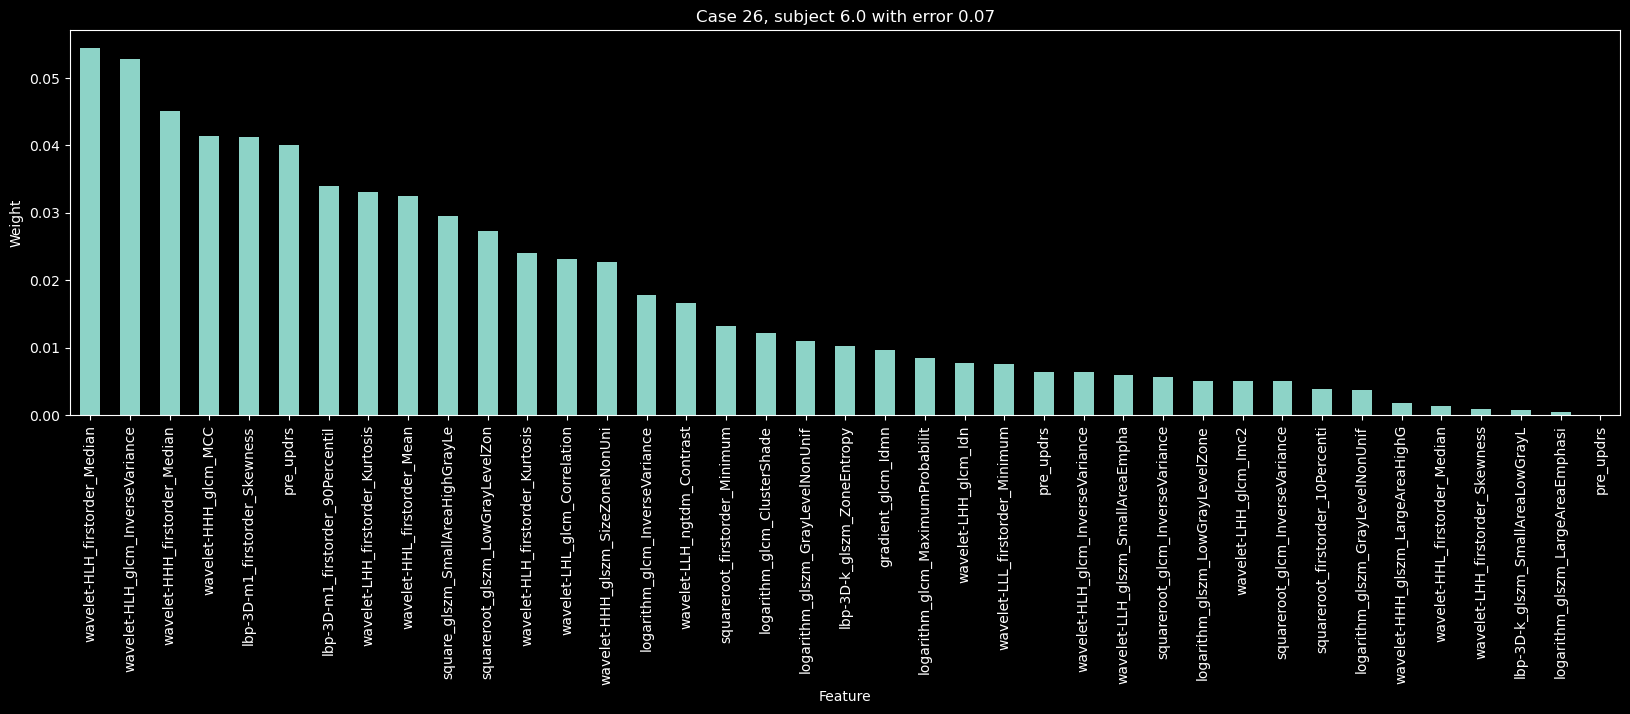

Lasso predicts 0.72 for case with 0.89 with regularization 0.0001 and neighbor  [0.7037037]


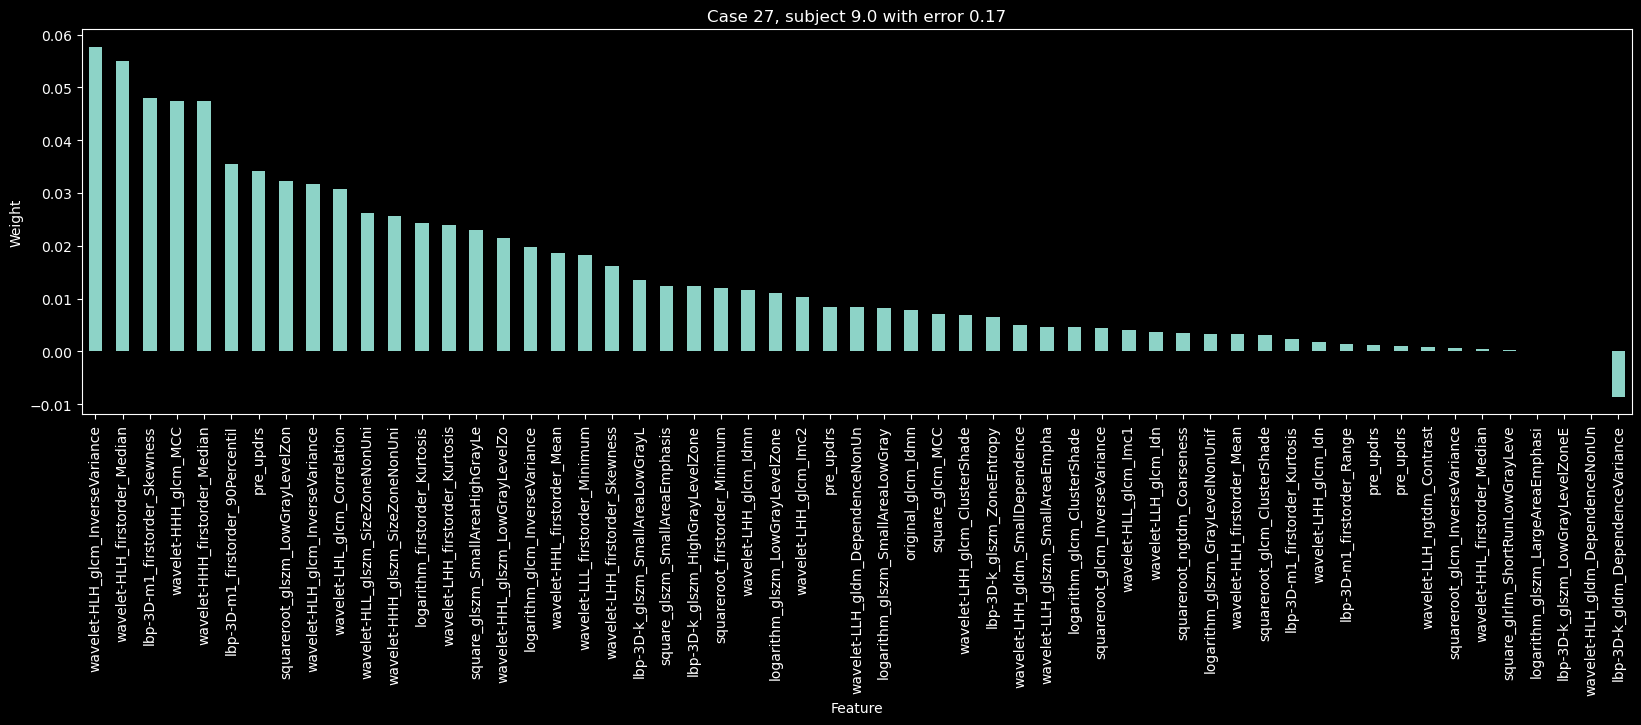

In [13]:
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    # Cross validation
    cvn = 6
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,test_index,pre_updrs_off)
    X_test_ss0 = X_test_ss0.reshape(X_test_ss0.shape[0],X_test_ss0.shape[1]*X_test_ss0.shape[2])

    with np.errstate(divide='ignore', invalid='ignore'):
      # Feature selection
      sel = skf.SelectKBest(skf.r_regression,k=2000)
      #sel = skf.SequentialFeatureSelector(slm.Lasso(), n_features_to_select= 100, cv=cvn, n_jobs=-1)
      X0_ss = sel.fit_transform(X0_ss0,y_train)
      X_test_ss = sel.transform(X_test_ss0)
      Ks.append(sel.transform(K.reshape(1, -1)))
      y_n = cKDTree(X0_ss).query(X_test_ss, k=1)[1]
    # SMOGN
    #X_smogn,y_smogn = util.rad_smogn(X0_ss,y_train,np.min(y_train),np.median(y_train),0.5,1,0.5,0.001)
    #X0_ss = np.vstack((X0_ss,X_smogn))
    #y_train = np.hstack((y_train,y_smogn))
    # LASSO
    lasso = slm.LassoCV(max_iter=1e4,cv=cvn,n_jobs=-1)
    est_ls = lasso.fit(X0_ss,y_train)
    results_ls[j] = est_ls.predict(X_test_ss)
    w.append(est_ls.coef_)
    print('Lasso predicts',str(np.round(results_ls[j],2)),
          'for case with',str(np.round(per_change[j],2)),
          'with regularization',str(np.round(est_ls.alpha_,4)),
          'and neighbor ',str(y_train[y_n]))
    # glasso = GroupLassoCV(groups=X0_ss.shape[1]//2,max_iter=1e4,cv=cvn,n_jobs=-1,alphas=alphas)
    # est_gls = glasso.fit(X0_ss,y_train)
    # results_gls[j] = est_gls.predict(X_test_ss)
    # print('GLasso predicts',str(np.round(results_gls[j],2)),
    #       'for case with',str(np.round(per_change[j],2)),
    #       'with regularization',str(np.round(est_gls.alpha_,4)))
    gerror[j] = np.sqrt((results_ls[j]-per_change[j])**2)
    Kst = Ks[j].ravel()
    wst = w[j]
    arr1inds = wst.argsort()
    wst = wst[arr1inds[::-1]]
    Kst = Kst[arr1inds[::-1]]
    df = pd.DataFrame({'Feature':(Kst[wst != 0]).tolist(),'Weight':(wst[wst != 0]).tolist()})
    ax = df.plot.bar(x='Feature', y='Weight', rot=0)
    ax.plot()
    ax.get_legend().remove()
    plt.ylabel('Weight')
    plt.xticks(rotation=90)
    plt.title('Case ' + str(int(j)) + ', subject ' + str(subsc[j]) + ' with error ' + str(np.round(gerror[j],2)))
    plt.rcParams["figure.figsize"] = (20,5)
    plt.style.use('dark_background')
    plt.show()

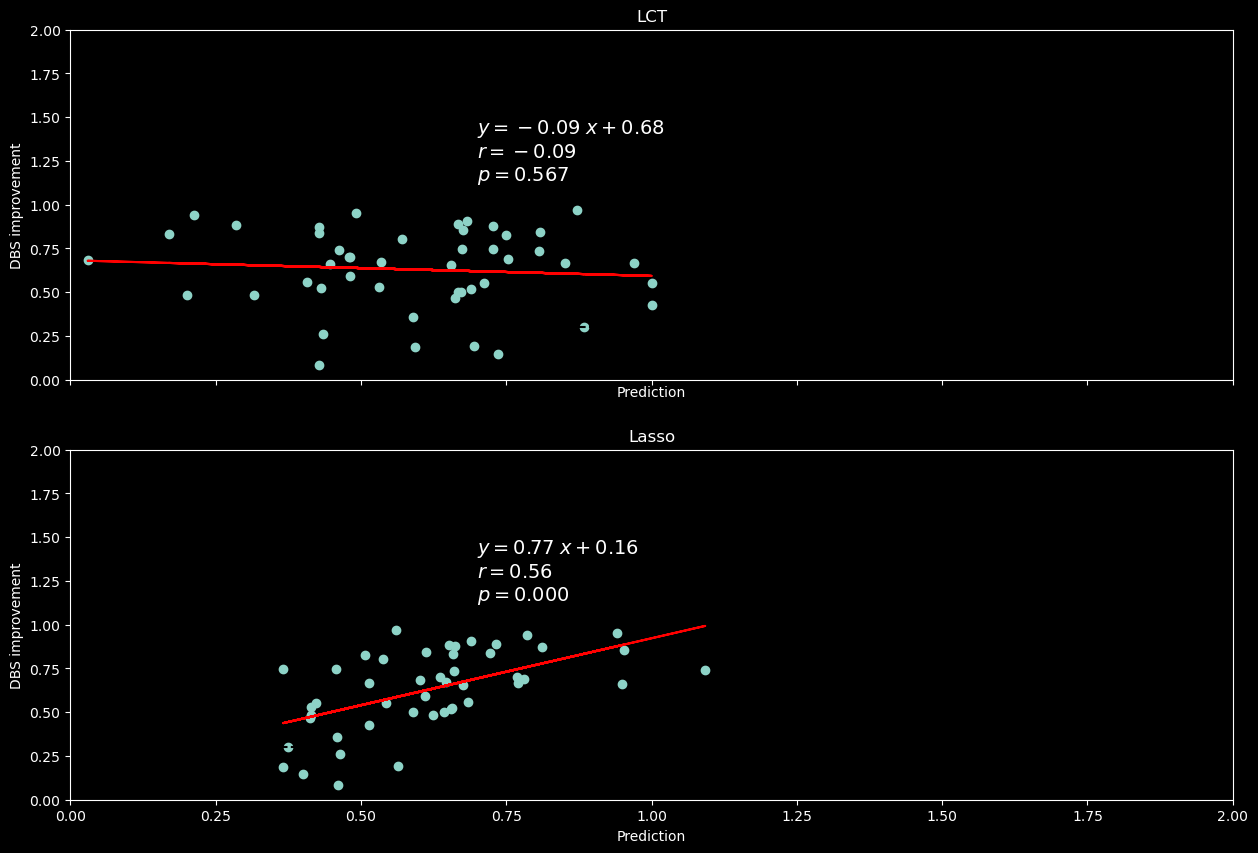

In [ ]:
util.eval_prediction(np.vstack((pre_imp,
                            #   results_mls,
                               results_ls,
                            #   results_gls,
                            #   results_bls,
                            #    results_en[:np.sum(results_lr.ravel()!=0.)],
                            #    results_rr.ravel()[:np.sum(results_lr.ravel()!=0.)],
                            #    results_svr[:np.sum(results_lr.ravel()!=0.)],
                               )),
                               per_change,
                               ['LCT',
                            #    'Manual Lasso',
                                'Lasso',
                           #     'Group Lasso',
                                # 'ElasticNet',
                                # 'Ridge',
                                # 'SVR',
                                ],(30,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')